# 今回の取り組み

- ⬜ `R10`において、アルビノのサンプル(`barcode31`)でも非常に細かくクラスタリングされてしまいました
    - **まずは`barcode31`のクラスタリングを見直します**

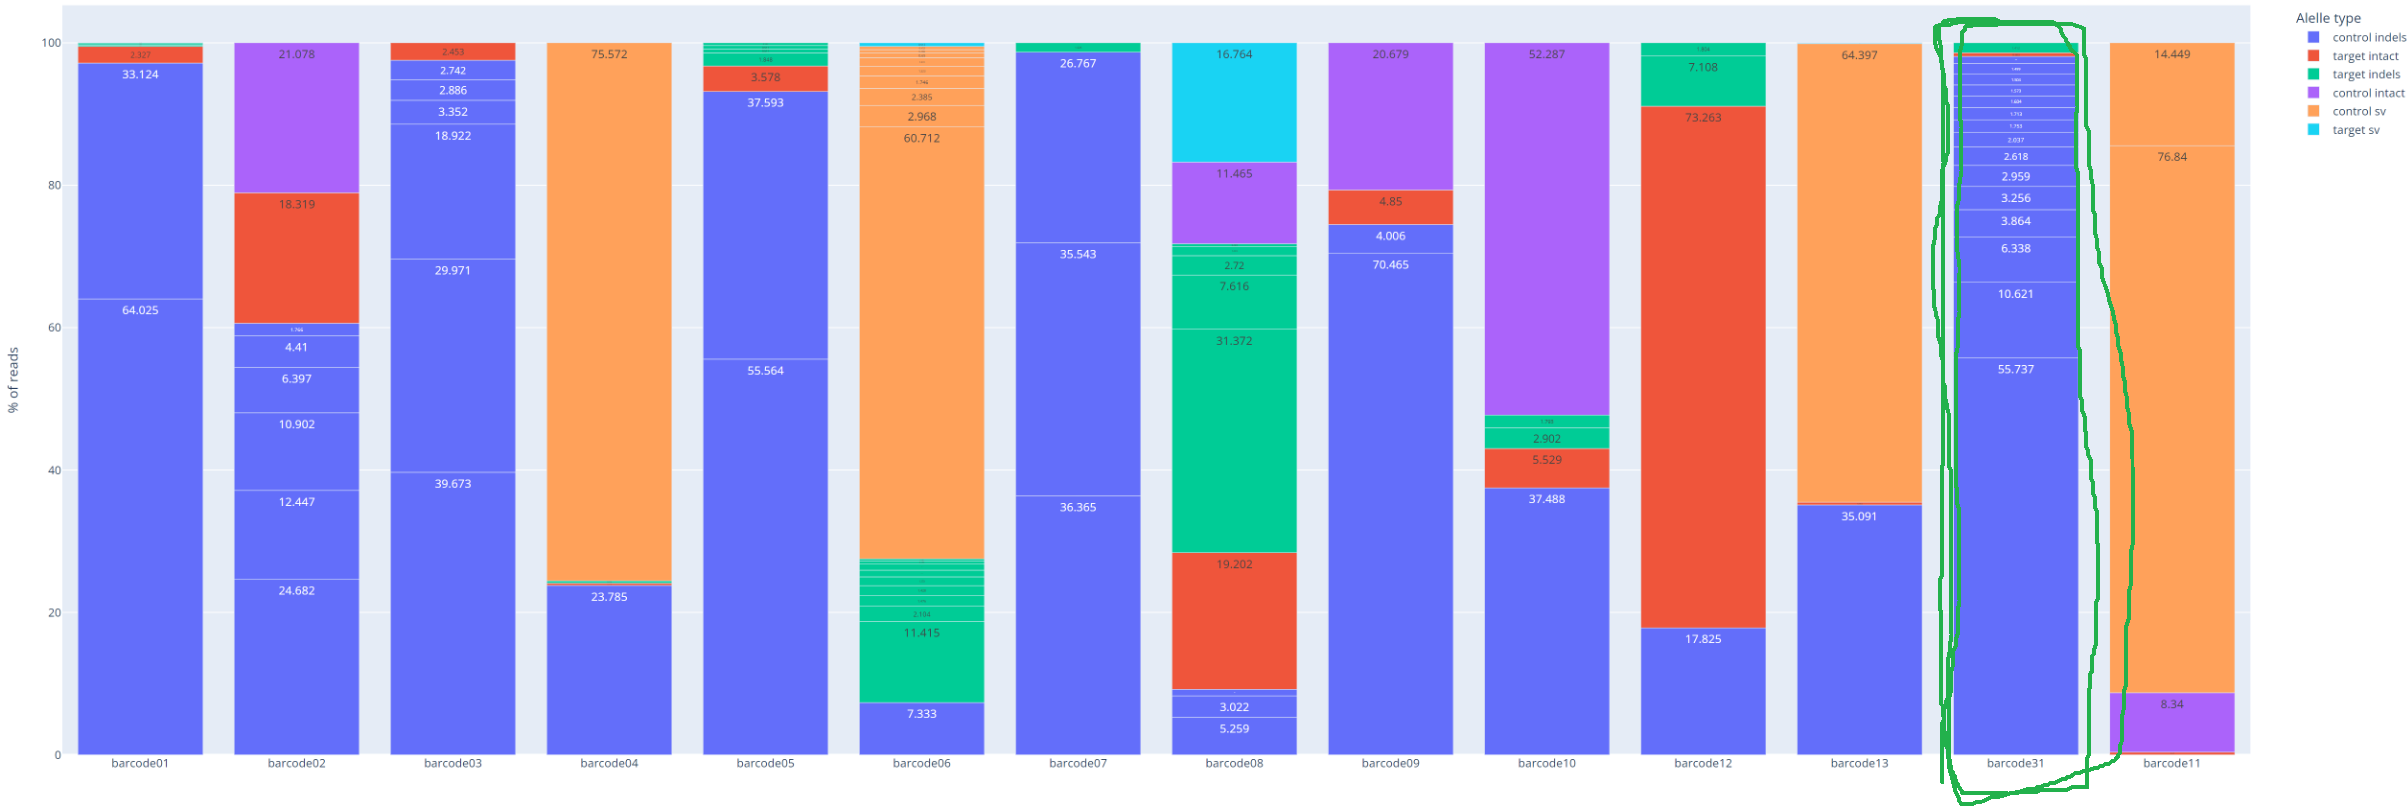

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
pip uninstall -qy DAJIN2
# pip install -q -e .
# pipの更新
# pip install -q -U pip
# pip install -q -U -r requirements.txt

# 実験

In [4]:
from __future__ import annotations
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

####* R10, Albino
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/r10_barcode31.fq.gz",
    "misc/data/r10_barcode32.fq.gz",
    "misc/data/tyr_control.fasta",
    "single-r10",
    "mm10",
    True,
    30,
)



######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "clustering", "report", "result", "mutation_loci"]
SUBDIRS_REPORT = ["HTML", "FASTA", "BAM", ".igvjs"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SUBDIRS_REPORT, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-r10...


In [5]:
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
# ============================================================
# MIDSV conversion
# ============================================================
preprocess.call_midsv(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [6]:
import pickle
# ============================================================
# Extract mutation loci
# ============================================================
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)
with open(Path(TEMPDIR, "mutation_loci", f"{SAMPLE_NAME}.plk"), "wb") as p:
    pickle.dump(MUTATION_LOCI_ALLELES, p)
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)

In [7]:
classif_sample = classification.classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [8]:
clust_sample = clustering.add_labels(
        classif_sample, TEMPDIR, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS
    )

In [9]:
from collections import defaultdict
count_label = defaultdict(int)
for samp in clust_sample:
    count_label[samp["LABEL"]] += 1

print(count_label)

defaultdict(<class 'int'>, {1: 17925, 2: 6528})


- あれれ、2つに別れていて別に悪くないように思います…？

In [10]:
import midsv
import shutil

clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)
########################################################################
# Consensus call
########################################################################
# downsampling to 1000 reads in each LABEL
clust_subset_sample = consensus.subset_clust(clust_sample, 1000)
cons_percentage, cons_sequence = consensus.call_consensus(clust_subset_sample, MUTATION_LOCI_ALLELES)
allele_names = consensus.call_allele_name(cons_sequence, cons_percentage, FASTA_ALLELES)
cons_percentage = consensus.update_key_by_allele_name(cons_percentage, allele_names)
cons_sequence = consensus.update_key_by_allele_name(cons_sequence, allele_names)
RESULT_SAMPLE = consensus.add_key_by_allele_name(clust_subset_sample, allele_names)
RESULT_SAMPLE.sort(key=lambda x: x["LABEL"])
########################################################################
# Output Report：RESULT/FASTA/HTML/BAM/VCF
########################################################################
# RESULT
midsv.write_jsonl(RESULT_SAMPLE, Path(TEMPDIR, "result", f"{SAMPLE_NAME}.jsonl"))
# FASTA
for header, cons_seq in cons_sequence.items():
    cons_fasta = report.report_files.to_fasta(header, cons_seq)
    Path(TEMPDIR, "report", "FASTA", SAMPLE_NAME, f"{SAMPLE_NAME}_{header}.fasta").write_text(cons_fasta)
# HTML
for header, cons_per in cons_percentage.items():
    cons_html = report.report_files.to_html(header, cons_per)
    Path(TEMPDIR, "report", "HTML", SAMPLE_NAME, f"{SAMPLE_NAME}_{header}.html").write_text(cons_html)
# BAM
report.report_bam.output_bam_sample(
    TEMPDIR, RESULT_SAMPLE, SAMPLE_NAME, GENOME, GENOME_COODINATES, CHROME_SIZE, THREADS
)
for path_bam_igvjs in Path(TEMPDIR, "cache", ".igvjs").glob(f"{CONTROL_NAME}_control.bam*"):
    shutil.copy(path_bam_igvjs, Path(TEMPDIR, "report", ".igvjs", SAMPLE_NAME))


- Clusteringとしては悪くないようです
- Consensusのときに1000リードだけを評価しているので、そのせいでリード数の評価が誤ったものになっています
    - allele1は943, allele2は329となっていますが、実際にはもっとあるはずです

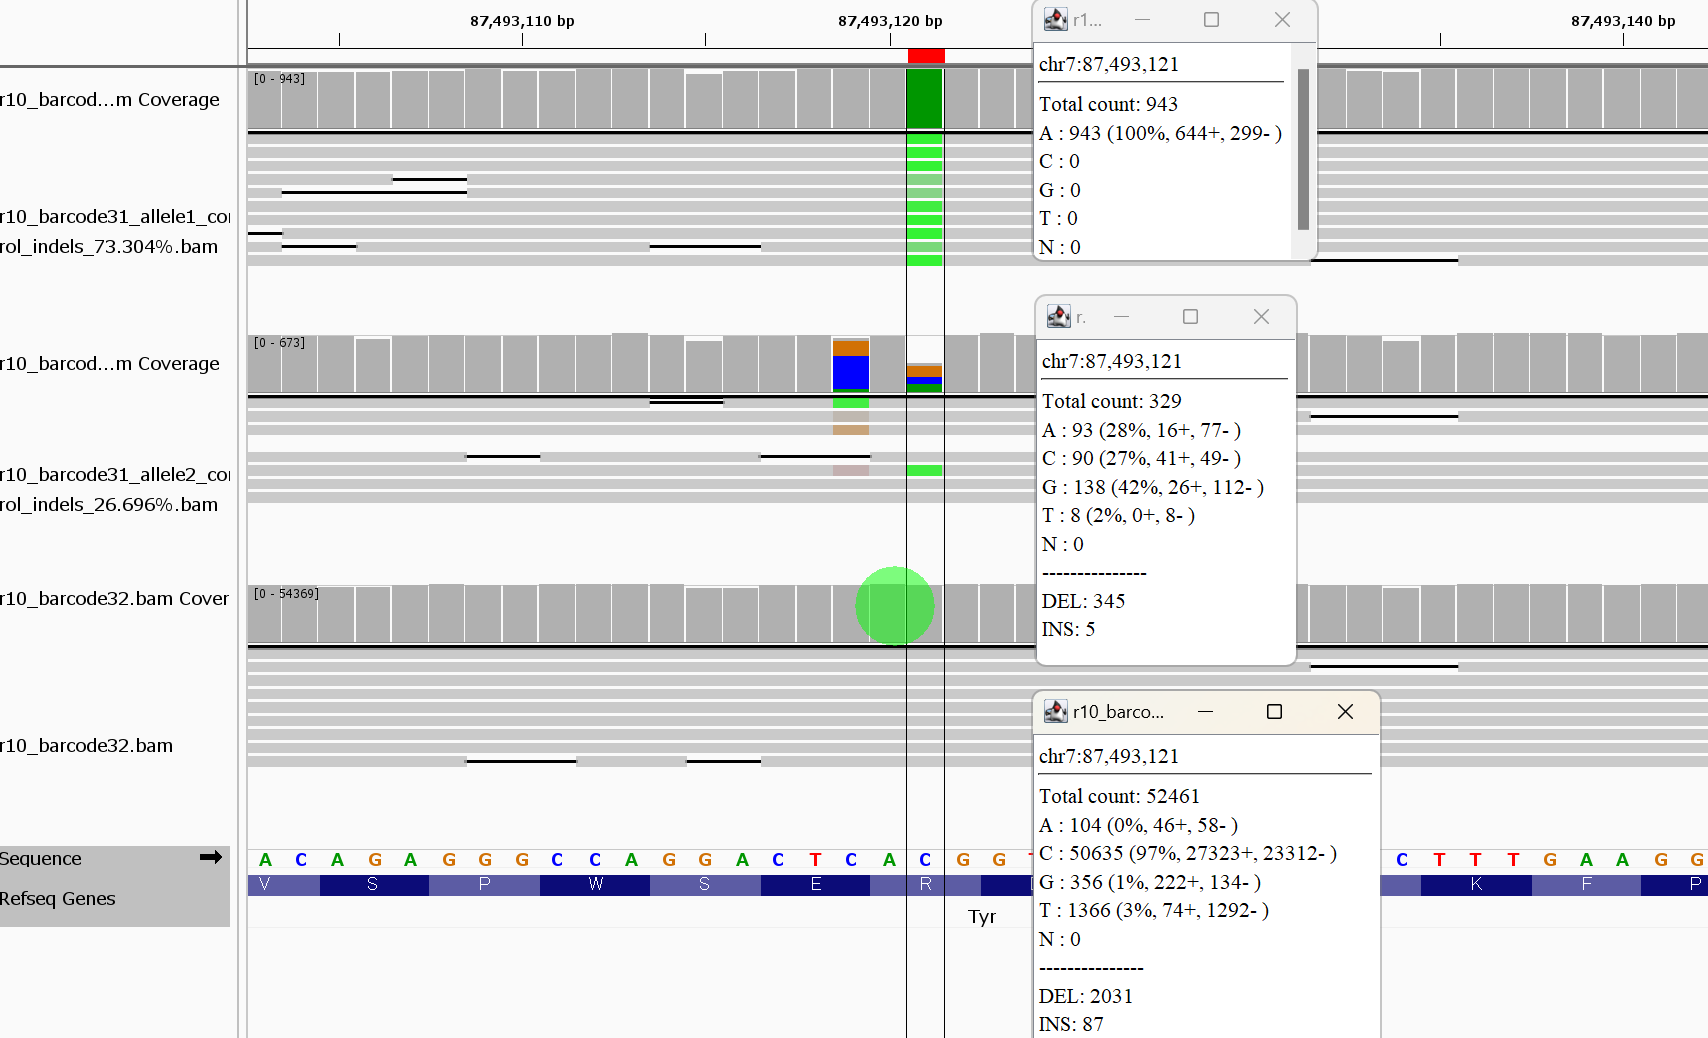

In [11]:
clust_sample[0]

{'QNAME': '0006507f-0c02-4a2e-bfac-54019beea950',
 'CSSPLIT': '=T,=G,=C,=A,=T,*TC,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,*TA,=A,=A,+C|*GA,=A,*TG,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,*AG,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,-A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,+A|+A|=A,=G,=C,-T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,+G|=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,-T,-G,-T,-C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,+C|=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T

In [13]:
RESULT_SAMPLE = consensus.add_key_by_allele_name(clust_sample, allele_names)
RESULT_SAMPLE.sort(key=lambda x: x["LABEL"])
########################################################################
# Output Report：RESULT/FASTA/HTML/BAM/VCF
########################################################################
# RESULT
midsv.write_jsonl(RESULT_SAMPLE, Path(TEMPDIR, "result", f"{SAMPLE_NAME}.jsonl"))
# FASTA
for header, cons_seq in cons_sequence.items():
    cons_fasta = report.report_files.to_fasta(header, cons_seq)
    Path(TEMPDIR, "report", "FASTA", SAMPLE_NAME, f"{SAMPLE_NAME}_{header}.fasta").write_text(cons_fasta)
# HTML
for header, cons_per in cons_percentage.items():
    cons_html = report.report_files.to_html(header, cons_per)
    Path(TEMPDIR, "report", "HTML", SAMPLE_NAME, f"{SAMPLE_NAME}_{header}.html").write_text(cons_html)
# BAM
report.report_bam.output_bam_sample(
    TEMPDIR, RESULT_SAMPLE, SAMPLE_NAME, GENOME, GENOME_COODINATES, CHROME_SIZE, THREADS
)
for path_bam_igvjs in Path(TEMPDIR, "cache", ".igvjs").glob(f"{CONTROL_NAME}_control.bam*"):
    shutil.copy(path_bam_igvjs, Path(TEMPDIR, "report", ".igvjs", SAMPLE_NAME))

- `RESULT_SAMPLE`の引数に`clust_sample_subset`ではなく`clust_sample`を指定することで全リードの出力に成功しました

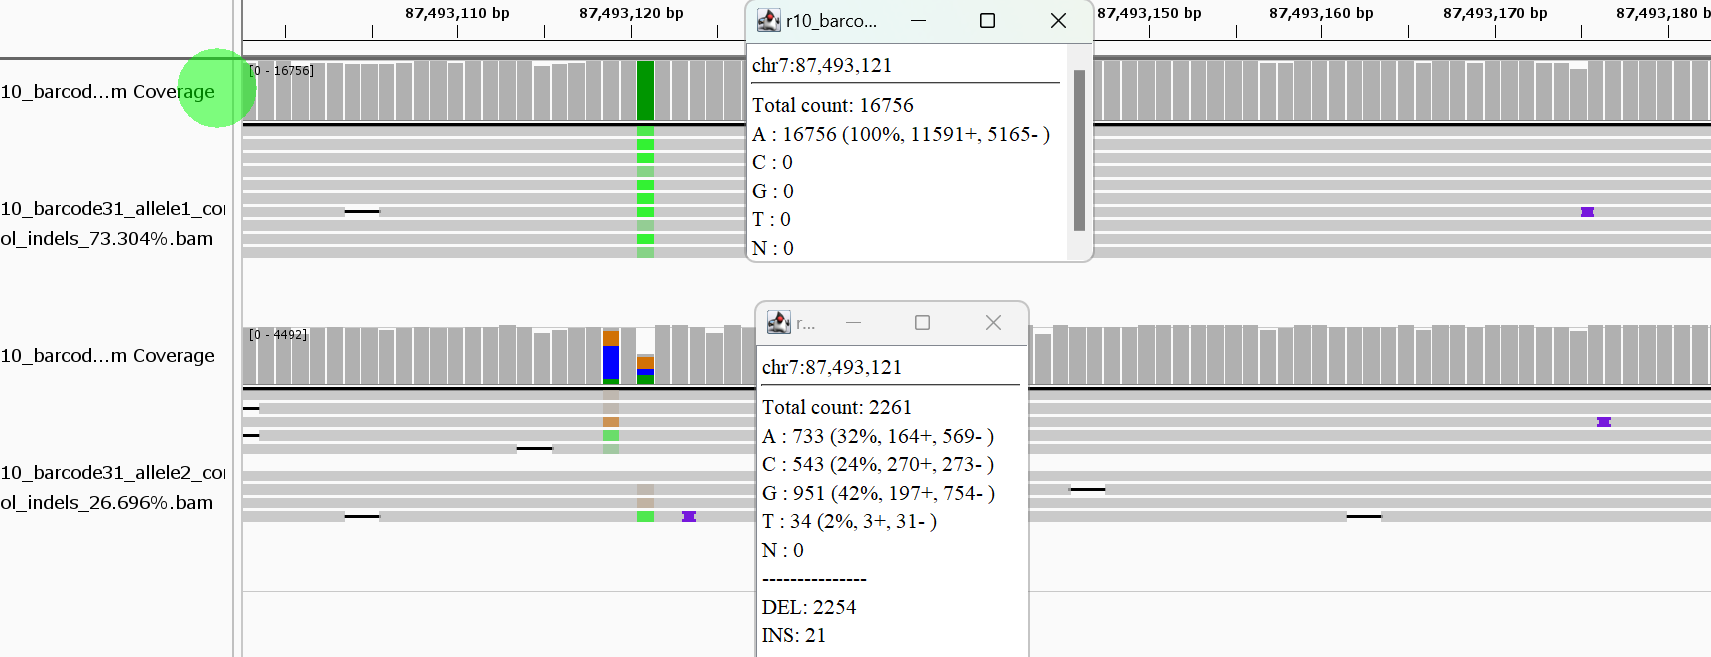

- 一方で、前回のバッチモードでやったときのように細かく別れすぎるという問題は再現できていません
    - いちどsingle-modeでDAJINを回してみます

In [15]:
%%bash
name="single-r10-albino"
rm -rf DAJINResults/"$name"
rm -rf DAJINResults/.tempdir/"$name"

pip install -q -e .
time DAJIN2 \
    --name "$name" \
    --sample "misc/data/r10_barcode31.fq.gz" \
    --control "misc/data/r10_barcode32.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

misc/data/r10_barcode32.fq.gz is now processing...
2023-06-02 10:10:10: Preprocess r10_barcode32...
2023-06-02 10:10:10: Mapping r10_barcode32...
2023-06-02 10:11:59: Call MIDSV r10_barcode32...
2023-06-02 10:12:19: Call MIDSV r10_barcode32...
misc/data/r10_barcode32.fq.gz is finished!
misc/data/r10_barcode31.fq.gz is now processing...
2023-06-02 10:13:30: Preprocess r10_barcode31...
misc/data/r10_barcode32.fq.gz is finished!
misc/data/r10_barcode31.fq.gz is now processing...
2023-06-02 10:13:52: Preprocess r10_barcode31...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 276, in main
    _execute_single_mode(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 42, in _execute_single_mode
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 144, in execute_sample
    MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/extract_mutation_loci.py", line 131, in extract_mutation_loci
    indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/extract_mutation_loci.py", line 16, in _count_indels
    for samp in midsv_sample:
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/p

2023-06-02 10:15:50: Classify r10_barcode31...
2023-06-02 10:16:00: Clustering r10_barcode31...
2023-06-02 10:18:55: Consensus calling r10_barcode31......
misc/data/r10_barcode31.fq.gz is finished...


Finished! Open DAJINResults/single-r10-albino to see the report.

real	9m20.403s
user	8m5.692s
sys	0m16.207s


- batchモードで見られた細かすぎる分類は再現できませんでした…

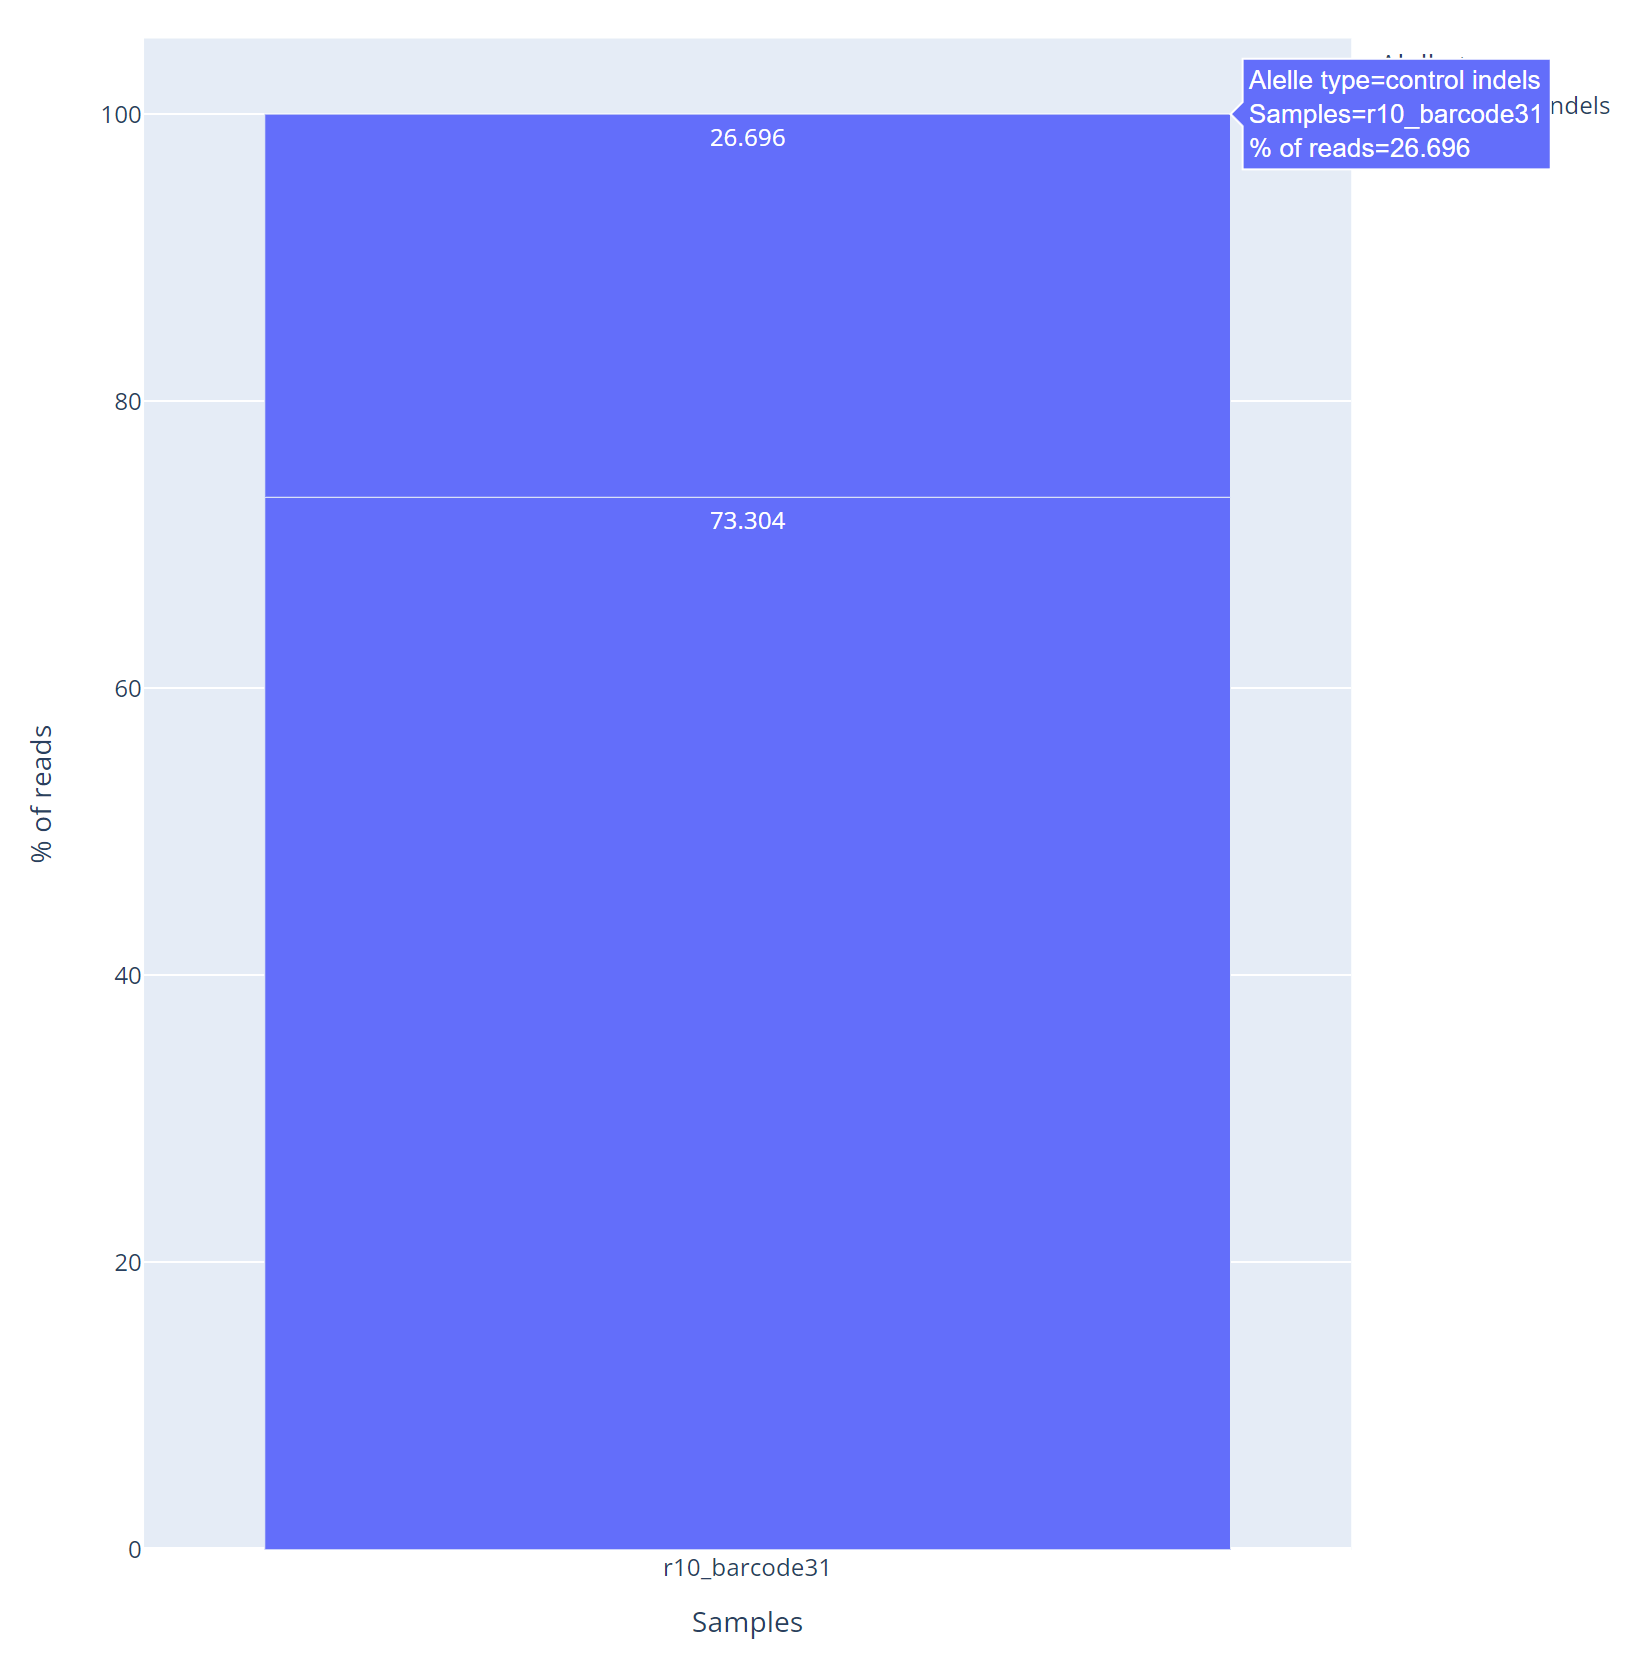

- barcode01と混ぜて、batchモードで行ってみます

In [21]:
%%bash
pip install -q -e .
time DAJIN2 batch -f misc/data/design_batch_tyr_r10.csv --threads 10

misc/data/r10_barcode32.fq.gz is now processing...
2023-06-02 10:33:05: Preprocess r10_barcode32...
2023-06-02 10:33:05: Mapping r10_barcode32...
2023-06-02 10:37:16: Call MIDSV r10_barcode32...
2023-06-02 10:40:00: r10_barcode32 is finished!
misc/data/r10_barcode31.fq.gz is now processing...
misc/data/r10_barcode01.fq.gz is now processing...
2023-06-02 10:40:02: Preprocess r10_barcode31...
2023-06-02 10:40:02: Preprocess r10_barcode01...
2023-06-02 10:44:02: Classify r10_barcode31...
2023-06-02 10:44:25: Clustering r10_barcode31...
2023-06-02 10:49:36: Consensus calling r10_barcode31......
2023-06-02 10:50:00: Classify r10_barcode01...
2023-06-02 10:50:03: r10_barcode31 is finished!
2023-06-02 10:51:06: Clustering r10_barcode01...
2023-06-02 10:57:56: Consensus calling r10_barcode01......
2023-06-02 10:59:11: r10_barcode01 is finished!


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 257, in main
    args.handler(args)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 220, in batchmode
    _execute_batch_mode(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 175, in _execute_batch_mode
    report.report(name)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/postprocess/report.py", line 57, in report
    shutil.copytree(dir, Path(report_directory, directory.stem), dirs_exist_ok=True)
  File "/home/kuno/miniconda/lib/python3.10/shutil.py", line 556, in copytree
    with os.scandir(src) as itr:
TypeError: scandir: path should be string, bytes, os.PathLike, integer or None, not builtin_function_or_method

real	26m18.268s
user	30m51.482s
sys	0m56.370s


CalledProcessError: Command 'b'pip install -q -e .\ntime DAJIN2 batch -f misc/data/design_batch_tyr_r10.csv --threads 10\n'' returned non-zero exit status 1.

In [22]:
from __future__ import annotations

import shutil
from pathlib import Path

import midsv
import pandas as pd
import plotly.express as px


def extract_all_info(batch_directory: Path) -> pd.DataFrame:
    df_results = pd.DataFrame()
    colum = ["SAMPLE", "QNAME", "NAME", "READNUM", "PERCENT", "LABEL", "ALLELE"]
    for path_result in sorted(batch_directory.iterdir()):
        sample_name = path_result.stem
        result_jsonl = midsv.read_jsonl(path_result)
        df_clust_sample = pd.DataFrame(result_jsonl)
        df_clust_sample["SAMPLE"] = sample_name
        df_clust_sample = df_clust_sample[colum]
        df_results = pd.concat([df_results, df_clust_sample])
    return df_results


def summarize_info(df_all: pd.DataFrame) -> pd.DataFrame:
    df_summary = df_all.drop(columns=["QNAME", "LABEL", "ALLELE"]).drop_duplicates()
    return df_summary


def output_plot(df_summary: pd.DataFrame, report_directory: Path):
    df_plot = df_summary.copy()
    name = df_plot.NAME.tolist()
    names = [n.split("_") for n in name]
    alleletype = [n[1] + " " + n[2] for n in names]
    df_plot["ALLELETYPE"] = alleletype
    fig = px.bar(
        df_plot,
        x="SAMPLE",
        y="PERCENT",
        color="ALLELETYPE",
        text="PERCENT",
        labels={"SAMPLE": "Samples", "PERCENT": "% of reads", "ALLELETYPE": "Alelle type"},
    )
    fig.update_traces(textposition="inside", cliponaxis=False)
    output_filename = str(Path(report_directory, "read_plot"))
    fig.write_html(f"{output_filename}.html")
    # if kaleido is installed, output a pdf
    try:
        fig.write_image(f"{output_filename}.pdf")
    except ValueError:
        pass


def report(name: str):
    report_directory = Path("DAJINResults", name)
    report_directory.mkdir(exist_ok=True, parents=True)
    for directory in Path("DAJINResults", ".tempdir", name, "report").iterdir():
        shutil.copytree(directory, Path(report_directory, directory.stem), dirs_exist_ok=True)
    df_all = extract_all_info(Path("DAJINResults", ".tempdir", name, "result"))
    df_all.to_csv(Path(report_directory, "read_all.csv"), index=False)
    df_summary = summarize_info(df_all)
    df_summary.to_csv(Path(report_directory, "read_summary.csv"), index=False)
    output_plot(df_summary, report_directory)


In [23]:
name = "batch_r10"
report(name)

- 悪くはないのですが、なぜか再現性が取れていません

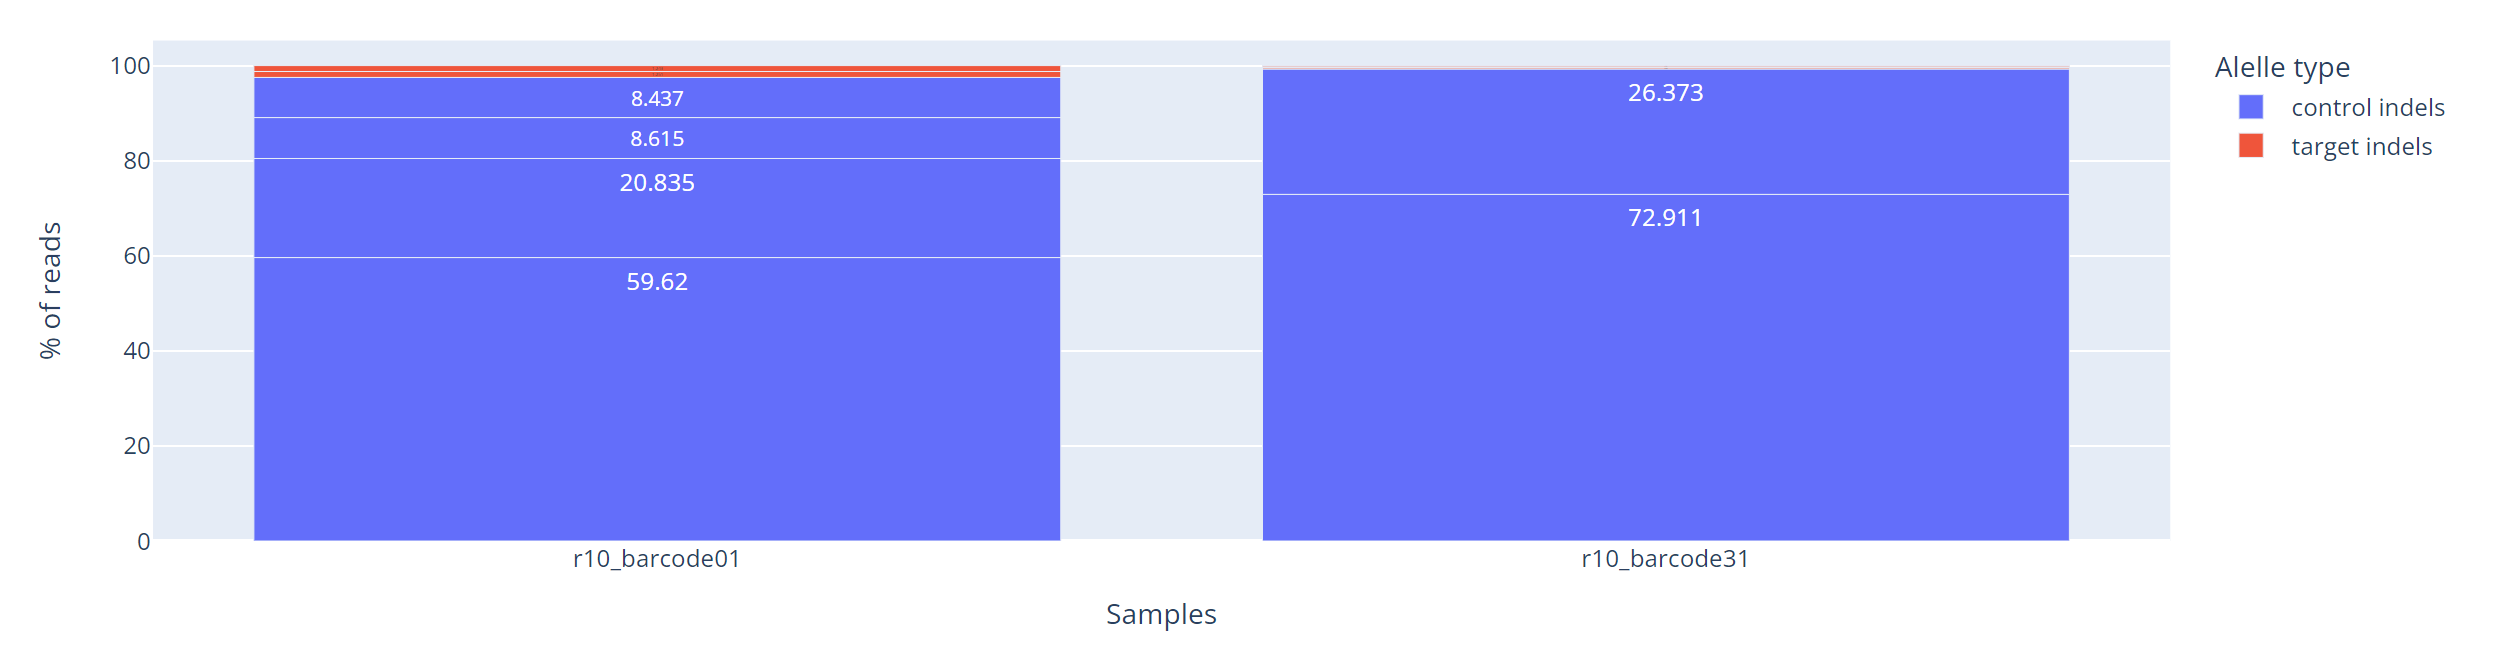

- クラスタリングは悪くありません
  - 強いて言うなら、allele2はさらに2アレルに分かれる可能性があります
  - ここを突き詰める前に、まずは再現性の問題を解決したいところです


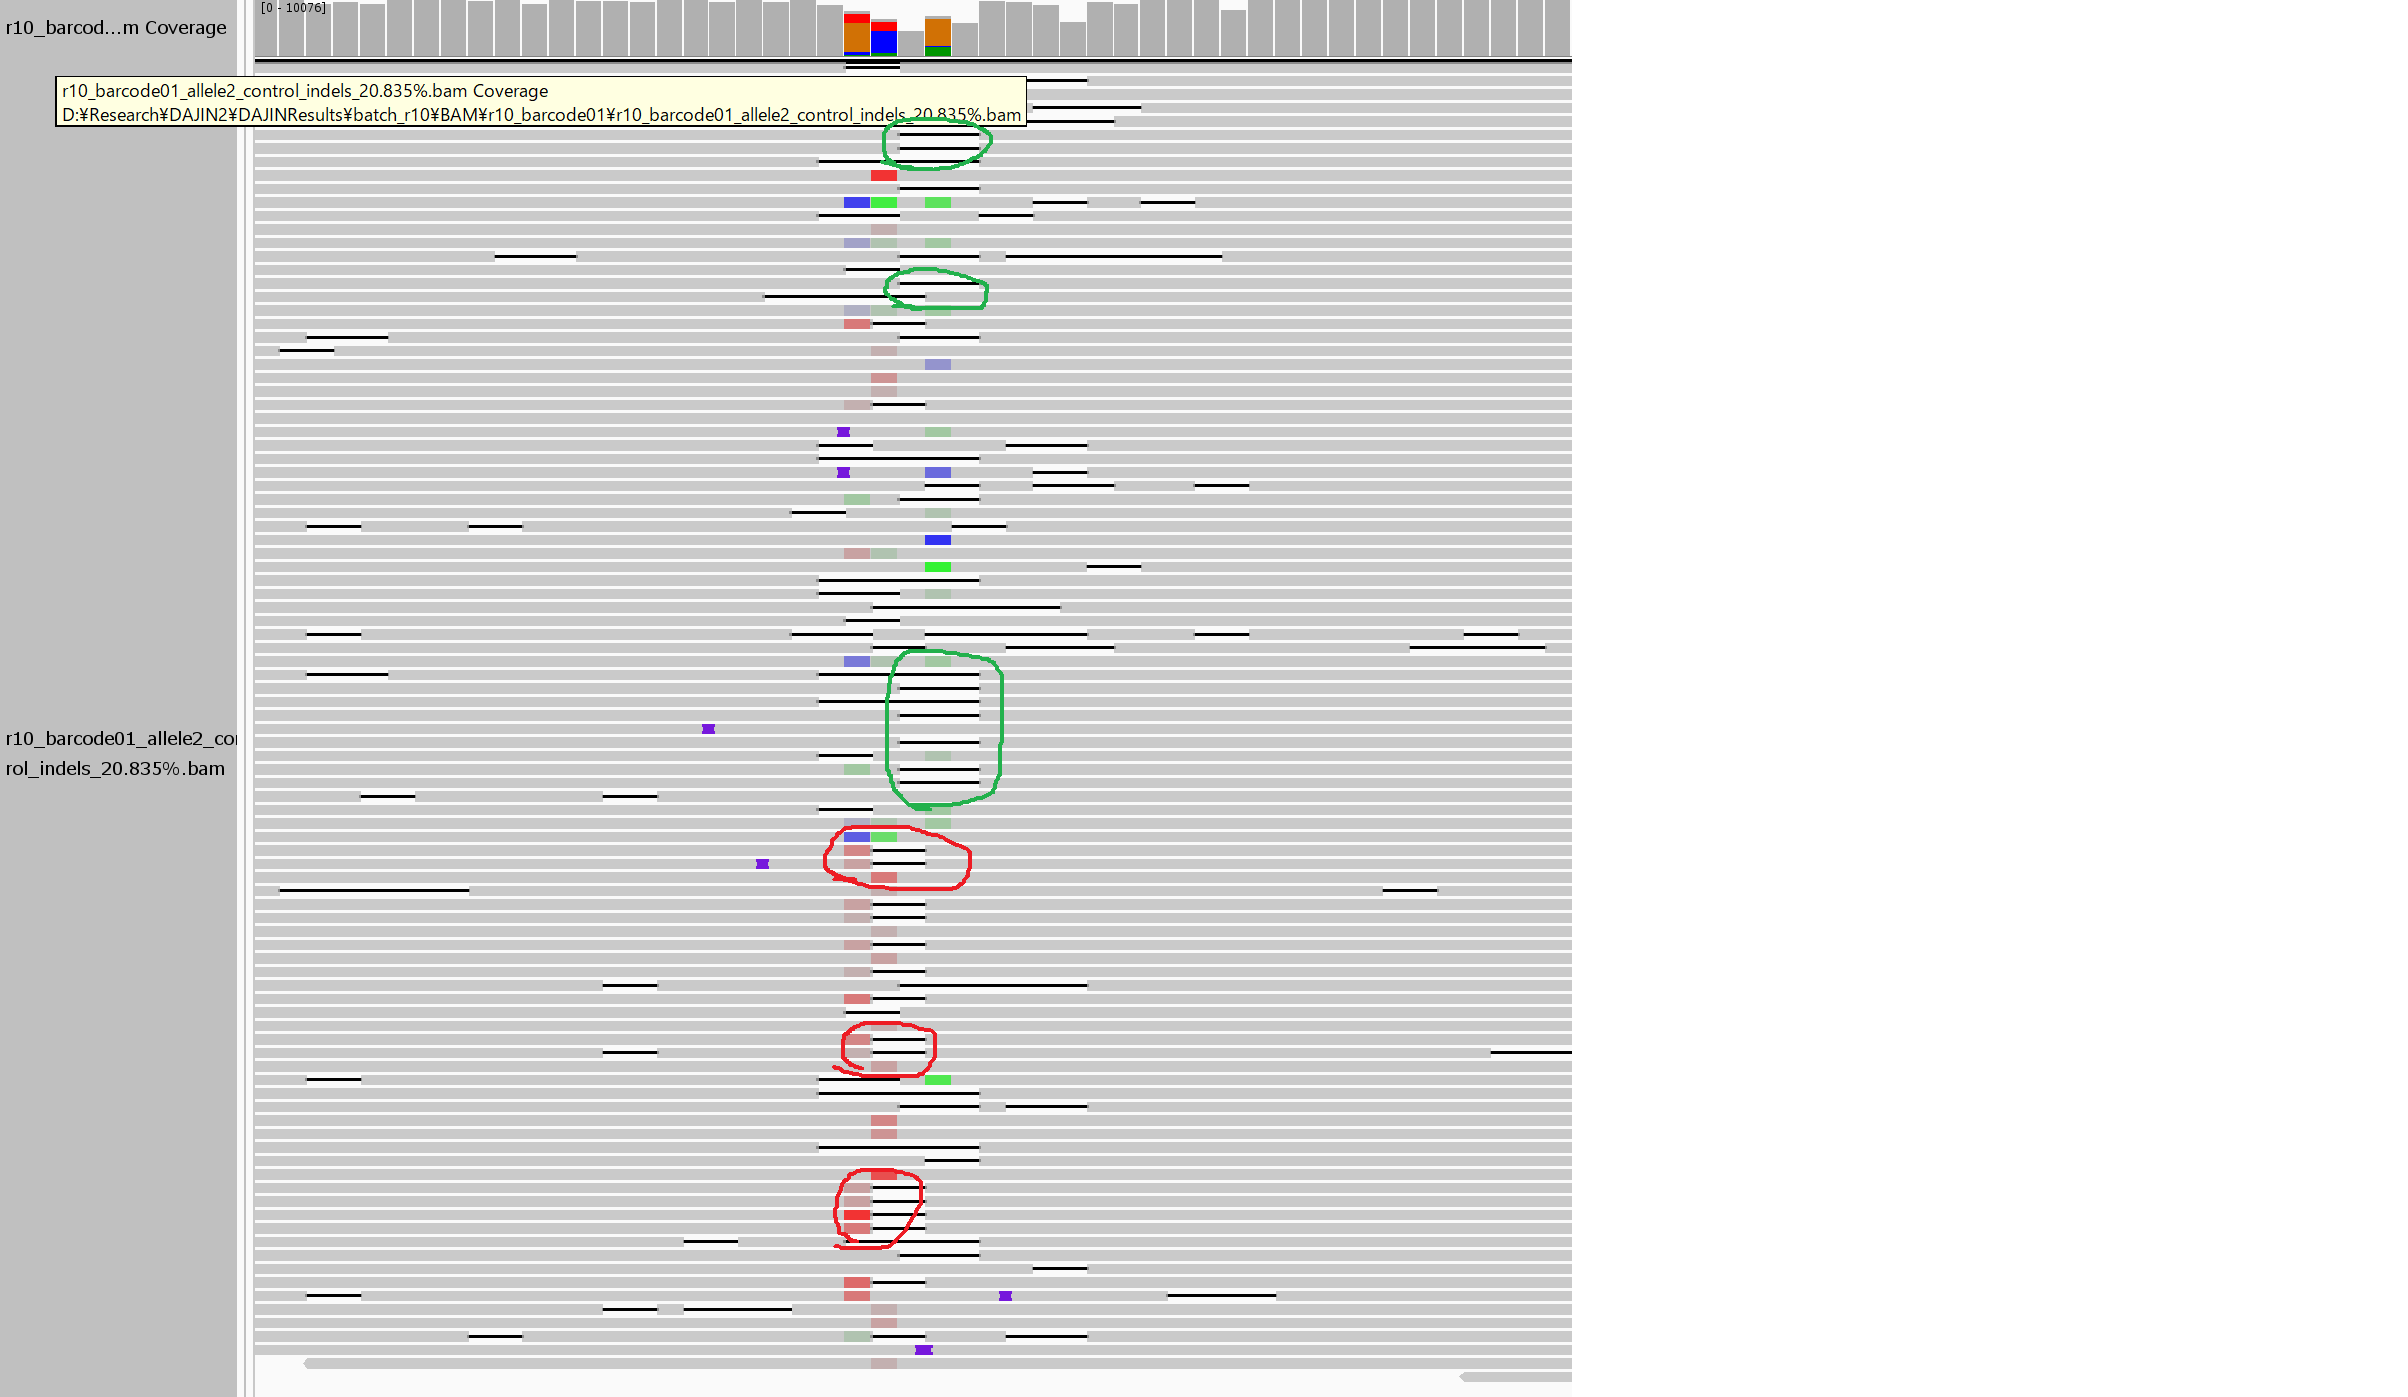

---
- ちなみに`report`の出力順をソートしました
  - 以下を追加して、CSVとHTML/PDFの出力順をサンプル名の順番にしました
  - `for path_result in batch_directory.iterdir():`に`sorted()`をつけました
  - `fig.update_xaxes(categoryorder="category ascending")`を加筆しました


- tyrの50%,10%,1%のデータでもテストしてみます

In [38]:
%%bash

pip install -q -e .

rm -rf DAJINResults/batch_tyr_50_10_01
rm -rf DAJINResults/.tempdir/batch_tyr_50_10_01

time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv -t 10

2023-06-02 14:29:19: misc/data/tyr_control.fq.gz is now processing...
2023-06-02 14:29:21: Preprocess misc/data/tyr_control.fq.gz...
2023-06-02 14:29:21: Mapping misc/data/tyr_control.fq.gz...
2023-06-02 14:29:39: Call MIDSV misc/data/tyr_control.fq.gz...
2023-06-02 14:29:54: 🍵 misc/data/tyr_control.fq.gz is finished!
2023-06-02 14:29:54: misc/data/tyr_albino_50%.fq.gz is now processing...
2023-06-02 14:29:54: misc/data/tyr_albino_10%.fq.gz is now processing...
2023-06-02 14:29:54: misc/data/tyr_albino_01%.fq.gz is now processing...
2023-06-02 14:29:56: Preprocess misc/data/tyr_albino_50%.fq.gz...
2023-06-02 14:29:56: Preprocess misc/data/tyr_albino_01%.fq.gz...
2023-06-02 14:29:57: Preprocess misc/data/tyr_albino_10%.fq.gz...
2023-06-02 14:30:23: Classify misc/data/tyr_albino_50%.fq.gz...
2023-06-02 14:30:26: Clustering misc/data/tyr_albino_50%.fq.gz...
2023-06-02 14:30:41: Classify misc/data/tyr_albino_01%.fq.gz...
2023-06-02 14:30:43: Classify misc/data/tyr_albino_10%.fq.gz...
2023-

- テストデータに対しては、とても良好です
- 実際、かなりゴールに近づいているように思います

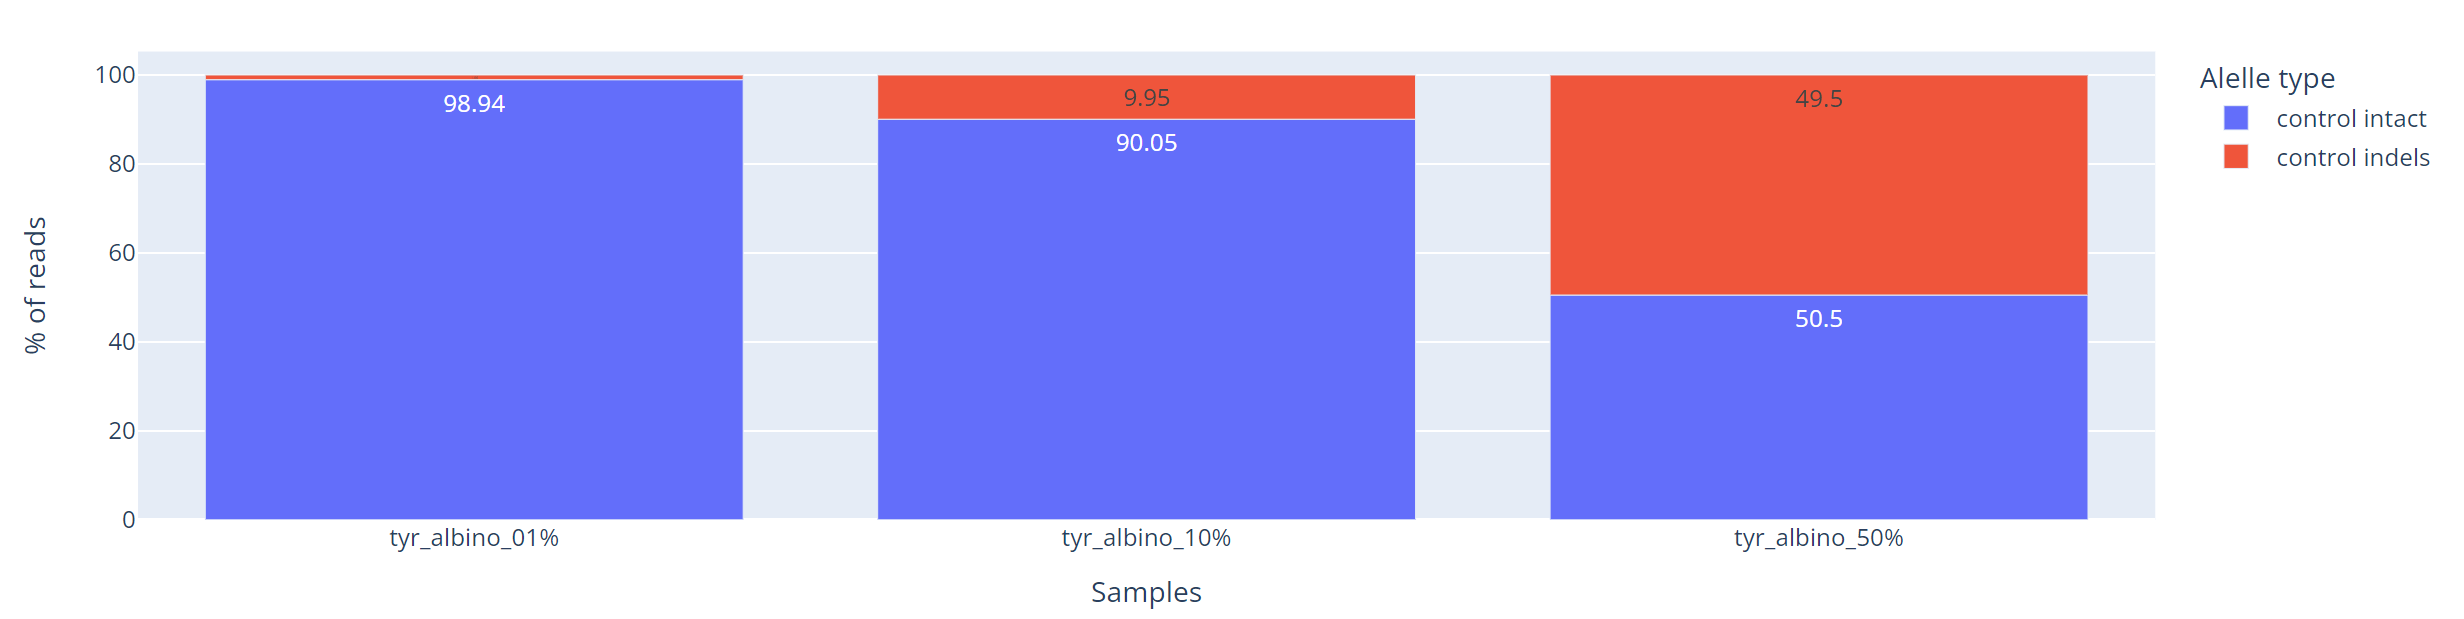

In [25]:
%%bash
pip install -q -e .

rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

2023-06-02 13:12:21: tests/data/knockout/test_barcode30.fq.gz is now processing...
2023-06-02 13:12:25: Preprocess tests/data/knockout/test_barcode30.fq.gz...
2023-06-02 13:12:25: Mapping tests/data/knockout/test_barcode30.fq.gz...
2023-06-02 13:12:41: Call MIDSV tests/data/knockout/test_barcode30.fq.gz...
2023-06-02 13:12:52: tests/data/knockout/test_barcode30.fq.gz is finished!
2023-06-02 13:12:52: tests/data/knockout/test_barcode25.fq.gz is now processing...
2023-06-02 13:12:54: Preprocess tests/data/knockout/test_barcode25.fq.gz...
2023-06-02 13:13:56: Classify tests/data/knockout/test_barcode25.fq.gz...
2023-06-02 13:14:01: Clustering tests/data/knockout/test_barcode25.fq.gz...
2023-06-02 13:14:28: Consensus calling tests/data/knockout/test_barcode25.fq.gz...
2023-06-02 13:14:37: tests/data/knockout/test_barcode25.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-stx2deletion to see the report.

real	2m30.996s
user	1m54.831s
sys	0m4.551s


- Stx2に対しても良好でした

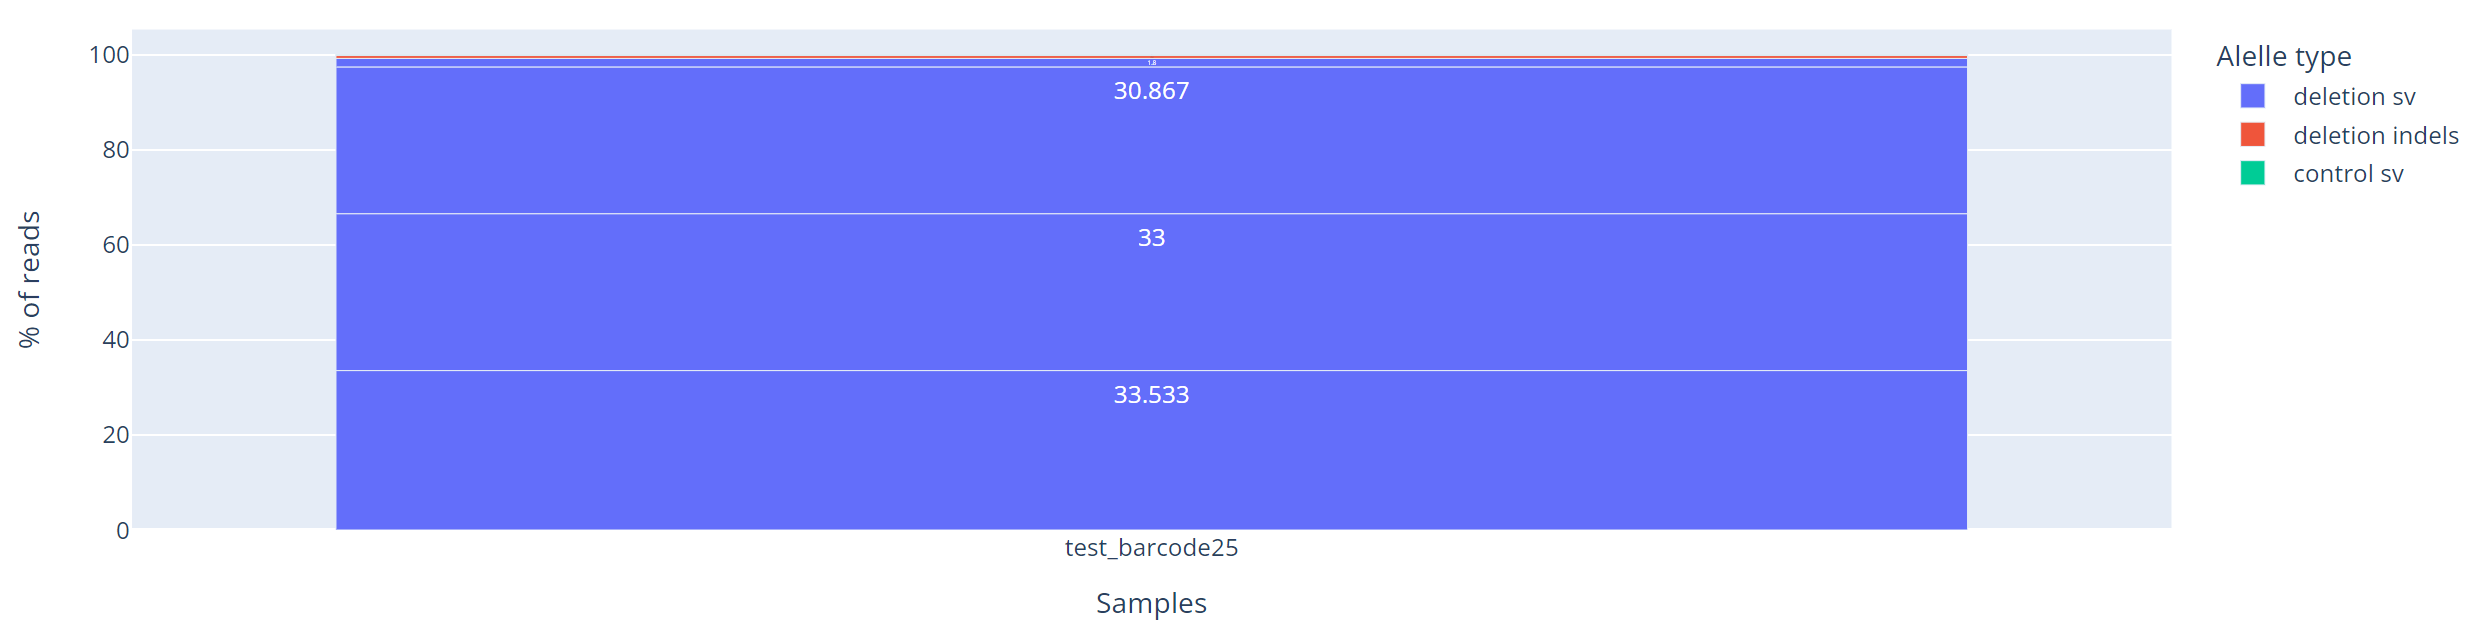

- 改めてR10のデータをBatchモードでやり直したところ、クラスタリングが細かすぎる問題が再現できました

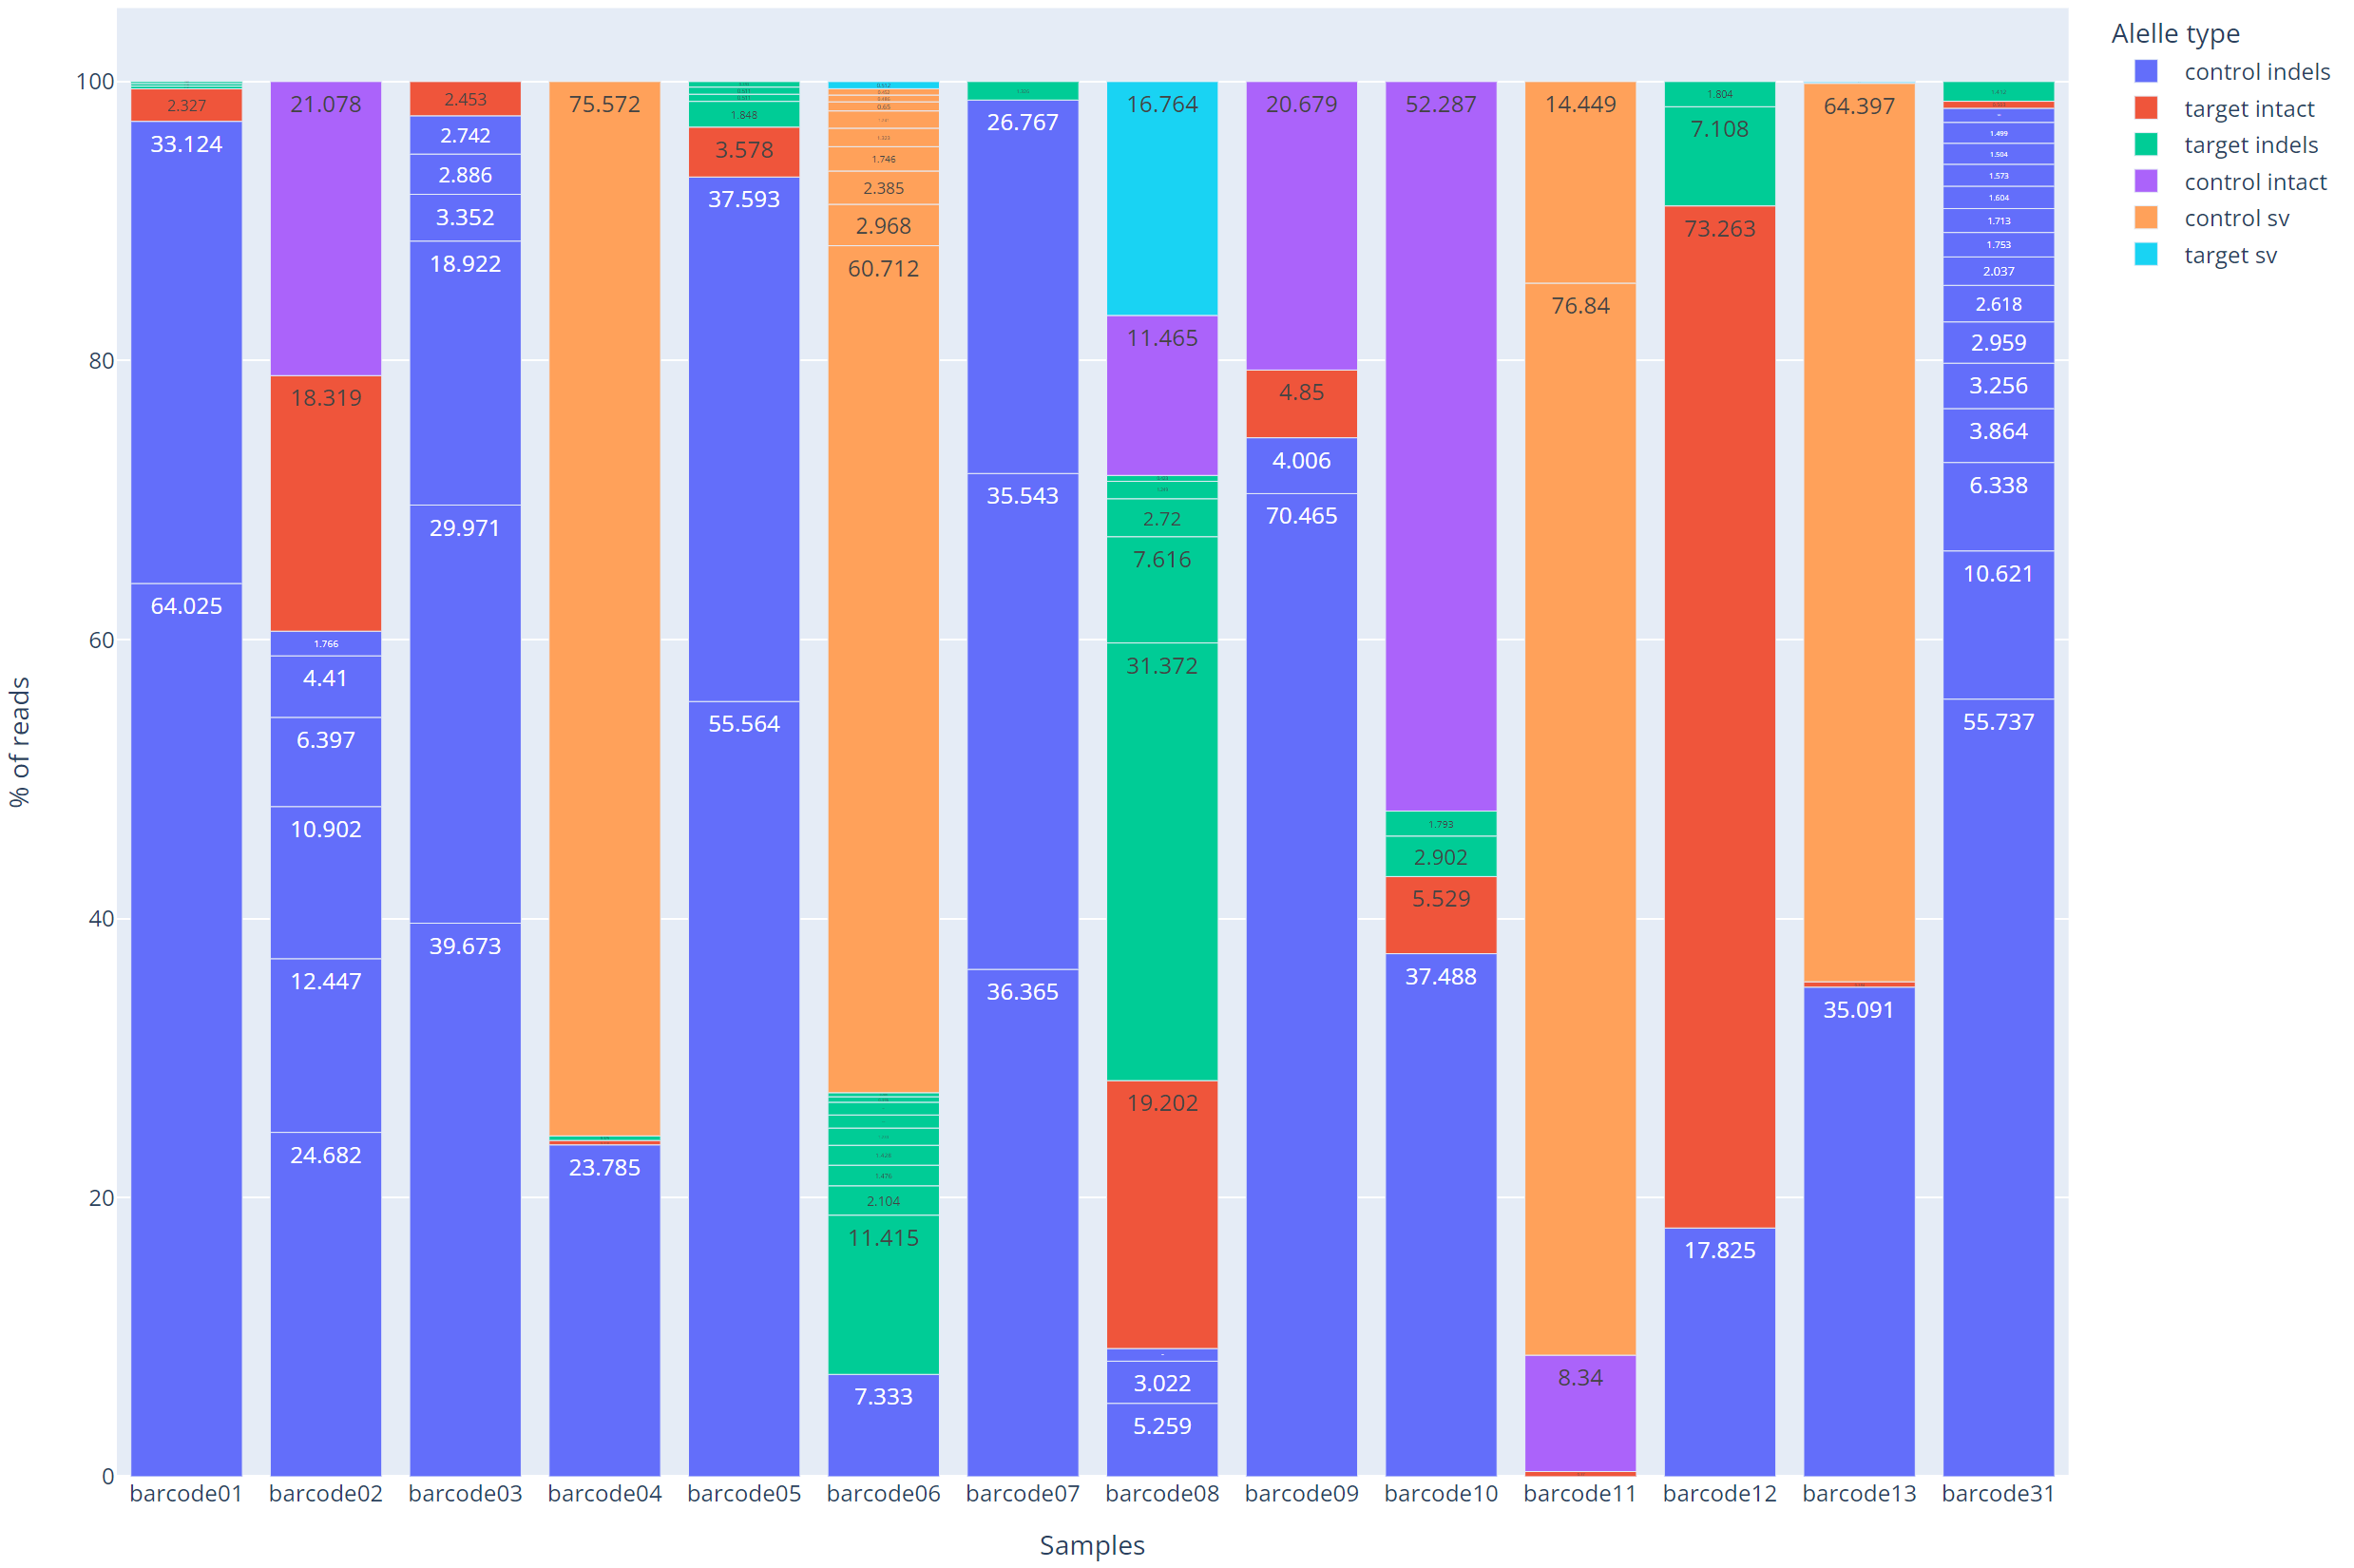

- 補正が効いていないのが原因のようです
    - allele4についてはAlbinoのほかにTの変異がありますが、これはControlにもあるのでシークエンスエラーとして無視すべきです

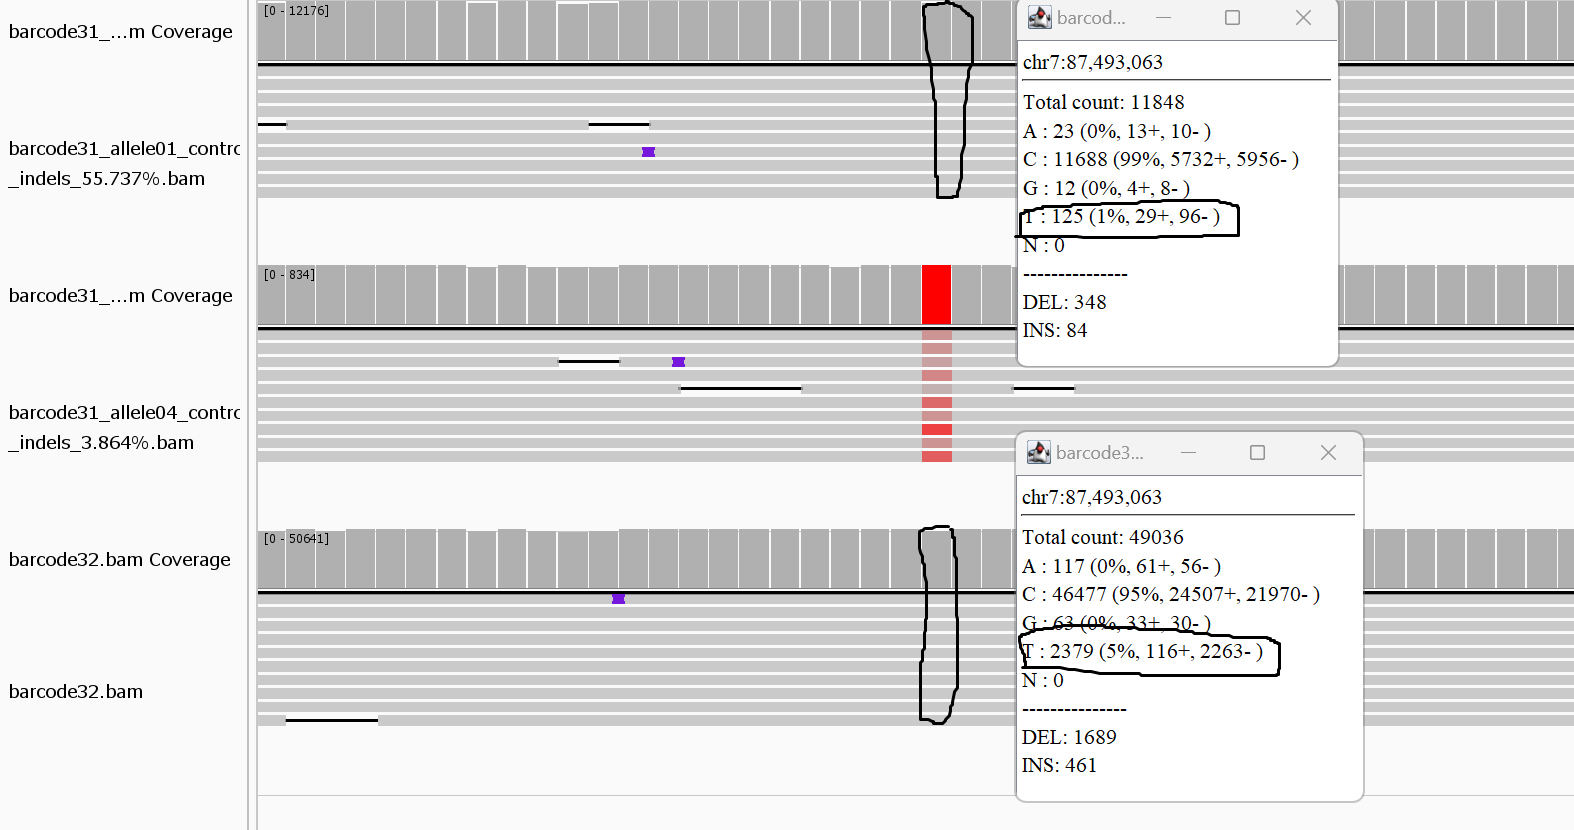

- こちらのワークスペースで使用していた`r10`のサンプルが違っていたので、置き換えました
- 再度、再現できるか施行します

In [39]:
%%bash
name="single-r10-albino"
rm -rf DAJINResults/"$name"
rm -rf DAJINResults/.tempdir/"$name"

pip install -q -e .
time DAJIN2 \
    --name "$name" \
    --sample "misc/data/r10_barcode31.fq.gz" \
    --control "misc/data/r10_barcode32.fq.gz" \
    --allele "misc/data/design_tyr_140_DAJIN2.fa" \
    --genome mm10 \
    --threads 10

2023-06-02 14:53:59: misc/data/r10_barcode32.fq.gz is now processing...
2023-06-02 14:54:01: Preprocess misc/data/r10_barcode32.fq.gz...
2023-06-02 14:54:01: Mapping misc/data/r10_barcode32.fq.gz...
2023-06-02 14:57:15: Call MIDSV misc/data/r10_barcode32.fq.gz...
2023-06-02 14:59:25: 🍵 misc/data/r10_barcode32.fq.gz is finished!
2023-06-02 14:59:25: misc/data/r10_barcode31.fq.gz is now processing...
2023-06-02 14:59:27: Preprocess misc/data/r10_barcode31.fq.gz...
2023-06-02 15:02:47: Classify misc/data/r10_barcode31.fq.gz...
2023-06-02 15:03:11: Clustering misc/data/r10_barcode31.fq.gz...
2023-06-02 15:08:02: Consensus calling misc/data/r10_barcode31.fq.gz...
2023-06-02 15:08:31: 🍵 misc/data/r10_barcode31.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-r10-albino to see the report.

real	14m52.438s
user	12m36.551s
sys	0m26.268s


- クラスタリングがダメダメな状況が再現できました！

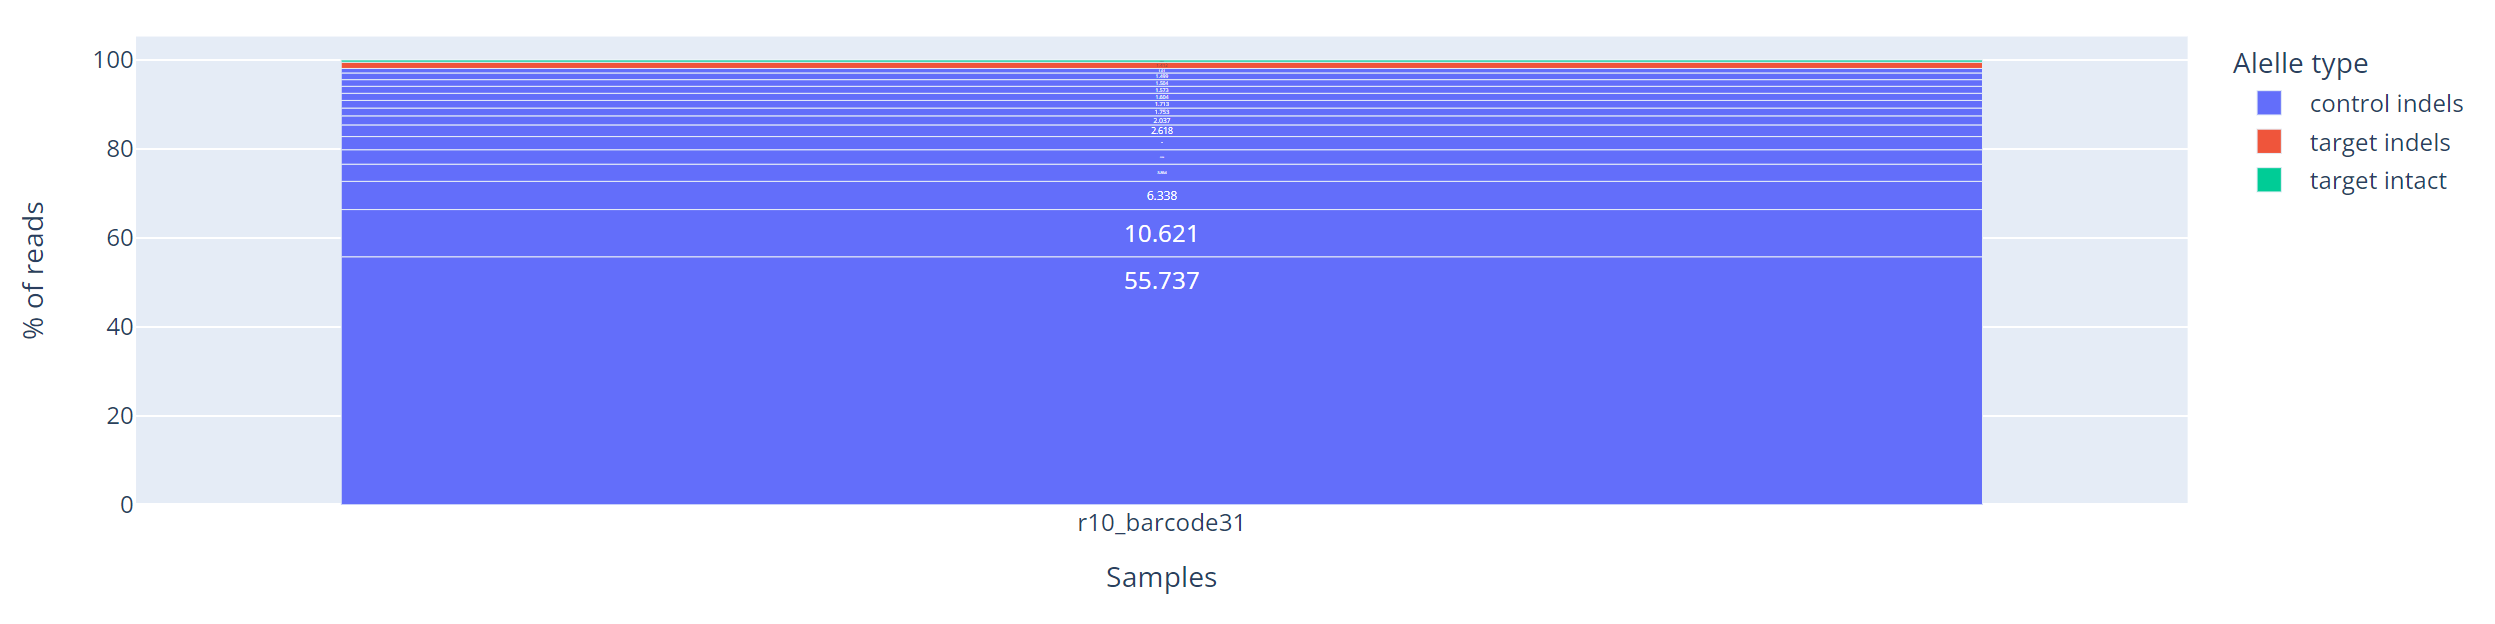

In [42]:
from __future__ import annotations
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

####* R10, Albino
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/r10_barcode31.fq.gz",
    "misc/data/r10_barcode32.fq.gz",
    "misc/data/design_tyr_140_DAJIN2.fa",
    "single-r10-albino",
    "mm10",
    True,
    30,
)



######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "clustering", "report", "result", "mutation_loci"]
SUBDIRS_REPORT = ["HTML", "FASTA", "BAM", ".igvjs"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SUBDIRS_REPORT, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-r10-albino...


In [ ]:
# for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
#     name_fasta = path_fasta.stem
#     preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
#     preprocess.mappy_align.output_sam(
#         TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
#     )
# # ============================================================
# # MIDSV conversion
# # ============================================================
# preprocess.call_midsv(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [43]:
import pickle
# ============================================================
# Extract mutation loci
# ============================================================
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)
with open(Path(TEMPDIR, "mutation_loci", f"{SAMPLE_NAME}.plk"), "wb") as p:
    pickle.dump(MUTATION_LOCI_ALLELES, p)
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)

In [53]:
print(FASTA_ALLELES["control"].index("GGACCTGCCAGTGCTCAGGCAACTTCAT"))
print(FASTA_ALLELES["control"].index("GGTTTCAACTGCGGAAACTG"))
print(FASTA_ALLELES["control"][886:895])

858
887
GGGTTTCAA


In [54]:
print(MUTATION_LOCI_ALLELES["control"][886])

{'-', '*'}


- `886`の点変異は、シークエンスエラーではないか？

In [55]:
from __future__ import annotations

import re
from collections import defaultdict
import json
import numpy as np
from pathlib import Path
from typing import Generator
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def _make_gen(reader):
    while True:
        b = reader(2**16)
        if not b:
            break
        yield b


def count_newlines(filepath):
    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count


def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"+": [0] * len_sequence, "-": [0] * len_sequence, "*": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["+"][i] += len(cs.split("|"))
                count["+"][i] += 1
            elif cs.startswith("-"):
                count["-"][i] += 1
            elif cs.startswith("*"):
                count["*"][i] += 1
    return count


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start:end])
            else:
                results[mut].append([0] * kmer)
    return results


def _extract_anomaly_loci(
    indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int
) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(
    indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]
) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [
            stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])
        ]
        # if pvalue == nan, samples and controls are exactly same.
        cossim_pval_false = [
            cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)
        ]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _transpose_mutation_loci(mutation_loci, len_sequence):
    mutation_loci_transposed = [set() for _ in range(len_sequence)]
    for mut, idx_mutation in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in idx_mutation:
                loci.add(mut)
    return mutation_loci_transposed


###########################################################
# main
###########################################################


def extract_mutation_loci(
    TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME: str
) -> dict[str, list[set[str]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        covarage_sample = count_newlines(filepath_sample)
        covarage_control = count_newlines(filepath_control)
        indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
        indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
        indels_kmer_sample = _split_kmer(indels_sample, kmer=10)
        indels_kmer_control = _split_kmer(indels_control, kmer=10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, covarage_sample, covarage_control)
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len(sequence))
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci_transposed})
    return MUTATION_LOCI_ALLELES


In [58]:
allele = "control"
sequence = FASTA_ALLELES[allele]

In [59]:
filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
covarage_sample = count_newlines(filepath_sample)
covarage_control = count_newlines(filepath_control)
indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
indels_kmer_sample = _split_kmer(indels_sample, kmer=10)
indels_kmer_control = _split_kmer(indels_control, kmer=10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, covarage_sample, covarage_control)
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)

- シークエンスエラーの補正が効いていない箇所は`886`のようです

In [63]:
idx = 886
print(idx in anomaly_loci["*"])
print(idx in dissimilar_loci["*"])

True
True


In [67]:
print(indels_kmer_sample["*"][idx])
print(indels_kmer_control["*"][idx])

[361, 341, 197, 433, 180, 1260, 318, 313, 294, 141]
[798, 748, 538, 1009, 445, 2552, 727, 785, 668, 432]


In [69]:
key = "*"
coverage_sample = count_newlines(filepath_sample)
coverage_control = count_newlines(filepath_control)
values_control = np.array(indels_kmer_control[key]) / covarage_control
values_sample = np.array(indels_kmer_sample[key]) / coverage_sample

In [74]:
value_control = values_control[idx]
value_sample = values_sample[idx]
clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
clf.fit(value_control.reshape(-1, 1))
pred = clf.predict(value_sample.reshape(-1, 1))

In [77]:
print(pred)
print(value_control[5])
print(value_sample[5])

[ 1  1  1  1  1 -1  1  1  1  1]
0.04665277320756097
0.05507233707766948


In [78]:
print(value_control)
print(value_sample)

[0.01458813 0.01367409 0.00983511 0.0184454  0.00813499 0.04665277
 0.01329019 0.01435048 0.01221162 0.00789733]
[0.01577866 0.0149045  0.00861052 0.01892565 0.00786748 0.05507234
 0.01389921 0.01368067 0.01285021 0.00616286]


In [79]:
mut = "*"
cossim = [1 - distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]

In [89]:
x = (1, 2, 3, 4, 5)
y = (1, 2, 3, 4, 5)
print(1 - distance.cosine(x, y))
print(stats.ttest_ind(x, y, equal_var=False)[1])

1
1.0


In [92]:
x = (1,1,1,1,1)
y = (10,10,10,10,10)
print(1 - distance.cosine(x, y))
print(stats.ttest_ind(x, y, equal_var=False)[1])

1
0.0


In [ ]:
x = (1,1,1,1,1)
y = (10,10,10,10,10)
print(1 - distance.cosine(x, y))
print(stats.ttest_ind(x, y, equal_var=False)[1])

In [80]:
print(cossim[idx])

0.003624513833184184


In [81]:
pvalues = [
            stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])
        ]

In [83]:
print(pvalues[idx])

0.04456827405969255


In [84]:
cossim_pval_false = [
            cossim if pvalue > 0.05 or np.isnan(pvalue) else 1 for cossim, pvalue in zip(cossim, pvalues)
        ]

In [85]:
print(cossim_pval_false[idx])

1

In [93]:
# Calculate cosine similarity: 1 means exactly same, 0 means completely different.
cossim = [1 - distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
# Calculate P values: nan means exactly same, p > 0.05 means similar.
pvalues = [
    stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])
]
# if pvalue == nan or pval > 0.05, samples and controls are very similar.
cossim_pval_filter = [
    1 if pvalue > 0.05 or np.isnan(pvalue) else cossim for cossim, pvalue in zip(cossim, pvalues)
]

In [96]:
print(cossim[idx])
print(pvalues[idx])
print(cossim_pval_filter[idx])

0.9963754861668158
0.04456827405969255
0.9963754861668158


In [98]:
idx_albino = 828
print(cossim[idx_albino])
print(pvalues[idx_albino])
print(cossim_pval_filter[idx_albino])

0.5950798321054362
0.5135237788441172
1


In [104]:
print(indels_kmer_sample[mut][idx_albino])
print(indels_kmer_control[mut][idx_albino])
coverage_sample = count_newlines(filepath_sample)
coverage_control = count_newlines(filepath_control)
x = indels_kmer_sample[mut][idx_albino]
y = indels_kmer_control[mut][idx_albino]
print(stats.ttest_ind(np.array(x) /coverage_sample, np.array(y)/coverage_control, equal_var=False))
# print(stats.ttest_ind(np.array(x) /coverage_sample, np.array(y)/coverage_control, equal_var=False))

[125, 196, 146, 227, 416, 18889, 626, 806, 145, 109]
[332, 584, 303, 685, 2475, 2033, 1153, 783, 292, 307]
Ttest_indResult(statistic=0.9635554030921467, pvalue=0.36029531668113046)


In [105]:
print(stats.bartlett(x, y))

BartlettResult(statistic=23.055995593513018, pvalue=1.573510536162189e-06)


In [108]:
kmer_sample = indels_kmer_sample[mut]
kmer_control = indels_kmer_control[mut]
f_pvalues = [stats.bartlett(x, y)[1] for x, y in zip(kmer_sample, kmer_control)]
print(f_pvalues[idx])
print(f_pvalues[idx_albino])



0.06483275347273006
1.573510536162189e-06


In [111]:
kmer_sample = indels_kmer_sample[mut]
kmer_control = indels_kmer_control[mut]
# Calculate cosine similarity: 1 means exactly same, 0 means completely different.
cossim = [1 - distance.cosine(x, y) for x, y in zip(kmer_sample, kmer_control)]
# Perform T-test: nan means exactly same, p > 0.05 means similar.
t_pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(kmer_sample, kmer_control)]
# Perform F-test: nan means exactly same, p > 0.05 means similar.
f_pvalues = [stats.bartlett(x, y)[1] for x, y in zip(kmer_sample, kmer_control)]
# if pvalue == nan or pval > 0.05, samples and controls are very similar.
cossim_pval_filter = [
    1 if (t_pval > 0.05 or np.isnan(t_pval)) and f_pval > 0.05 else cossim for cossim, t_pval, f_pval in zip(cossim, t_pvalues, f_pvalues)
]

In [112]:
print(cossim_pval_filter[idx])
print(cossim_pval_filter[idx_albino])

0.9963754861668158
0.5950798321054362


In [113]:
print(sum(1 for c in cossim_pval_filter if c == 1))

20


In [115]:
dissimilar_loci = {i for i, x in enumerate(cossim_pval_filter) if x < 0.90}
print(dissimilar_loci)

{832, 833, 824, 825, 826, 827, 828, 829, 830, 831}


- `extract_mutation_loci`のなかの`_extract_dissimilar_loci`を変更しました
    - まずはわかりやすいように類似度が高いものを1,低いものを0にしました
    - 類似度が高くて、T検定でもF検定でも有意差がないものをシークエンスエラーと定義しました
        - F検定の変わりに等分散性の検定であるbartlett検定を用いました

In [117]:
%%bash
name="single-r10-albino"

pip install -q -e .
time DAJIN2 \
    --name "$name" \
    --sample "misc/data/r10_barcode31.fq.gz" \
    --control "misc/data/r10_barcode32.fq.gz" \
    --allele "misc/data/design_tyr_140_DAJIN2.fa" \
    --genome mm10 \
    --threads 10

2023-06-02 17:44:24: misc/data/r10_barcode32.fq.gz is now processing...
misc/data/r10_barcode32.fq.gz is already preprocessed and reuse the results for the current run...
2023-06-02 17:44:25: misc/data/r10_barcode31.fq.gz is now processing...
2023-06-02 17:44:27: Preprocess misc/data/r10_barcode31.fq.gz...
2023-06-02 17:44:27: 🍵 misc/data/r10_barcode31.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-r10-albino to see the report.

real	4m35.557s
user	3m36.149s
sys	0m8.837s
2023-06-02 17:47:46: Classify misc/data/r10_barcode31.fq.gz...
2023-06-02 17:48:07: Clustering misc/data/r10_barcode31.fq.gz...
2023-06-02 17:52:31: Consensus calling misc/data/r10_barcode31.fq.gz...
2023-06-02 17:52:51: 🍵 misc/data/r10_barcode31.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-r10-albino to see the report.

real	8m50.832s
user	7m0.940s
sys	0m18.118s


- 改善しました！

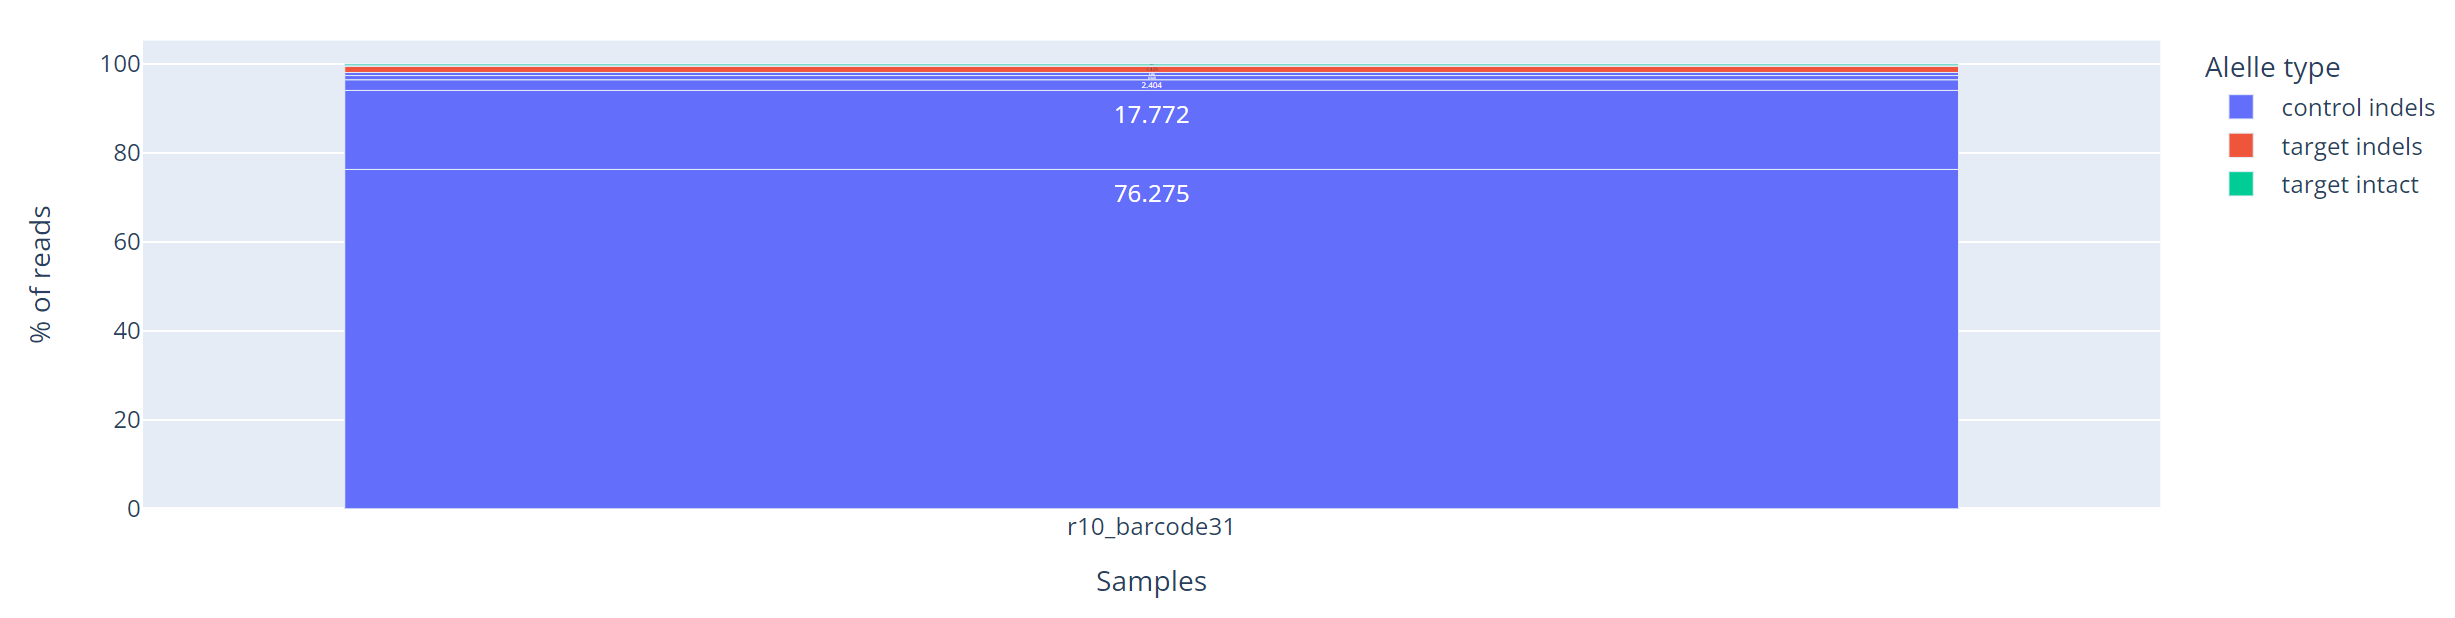

In [120]:
import pickle

with open(Path(TEMPDIR, "mutation_loci", f"{SAMPLE_NAME}.plk"), "rb") as p:
    MUTATION_LOCI_ALLELES = pickle.load(p)

In [123]:
print(MUTATION_LOCI_ALLELES["control"][idx])
print(MUTATION_LOCI_ALLELES["control"][idx_albino])

set()
{'*'}


- 👆無事にシークエンスエラー（886）のところはMUTATIONとしてカウントされないようになりました！
- 念のためテストデータで検証します

In [124]:
%%bash
pip install -q -e .
rm -rf DAJINResults/batch_tyr_50_10_01
rm -rf DAJINResults/.tempdir/batch_tyr_50_10_01

time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv -t 10

2023-06-03 08:00:22: misc/data/tyr_control.fq.gz is now processing...
2023-06-03 08:00:26: Preprocess misc/data/tyr_control.fq.gz...
2023-06-03 08:00:26: Mapping misc/data/tyr_control.fq.gz...
2023-06-03 08:00:46: Call MIDSV misc/data/tyr_control.fq.gz...
2023-06-03 08:01:01: 🍵 misc/data/tyr_control.fq.gz is finished!
2023-06-03 08:01:01: misc/data/tyr_albino_50%.fq.gz is now processing...
2023-06-03 08:01:02: Preprocess misc/data/tyr_albino_50%.fq.gz...
2023-06-03 08:01:29: Classify misc/data/tyr_albino_50%.fq.gz...
2023-06-03 08:01:31: Clustering misc/data/tyr_albino_50%.fq.gz...
2023-06-03 08:02:01: Consensus calling misc/data/tyr_albino_50%.fq.gz...
2023-06-03 08:02:08: 🍵 misc/data/tyr_albino_50%.fq.gz is finished!
2023-06-03 08:02:08: misc/data/tyr_albino_10%.fq.gz is now processing...
2023-06-03 08:02:10: Preprocess misc/data/tyr_albino_10%.fq.gz...
2023-06-03 08:02:52: Classify misc/data/tyr_albino_10%.fq.gz...
2023-06-03 08:02:57: Clustering misc/data/tyr_albino_10%.fq.gz...
20

- 無事に1%の変異も捕捉できていました！

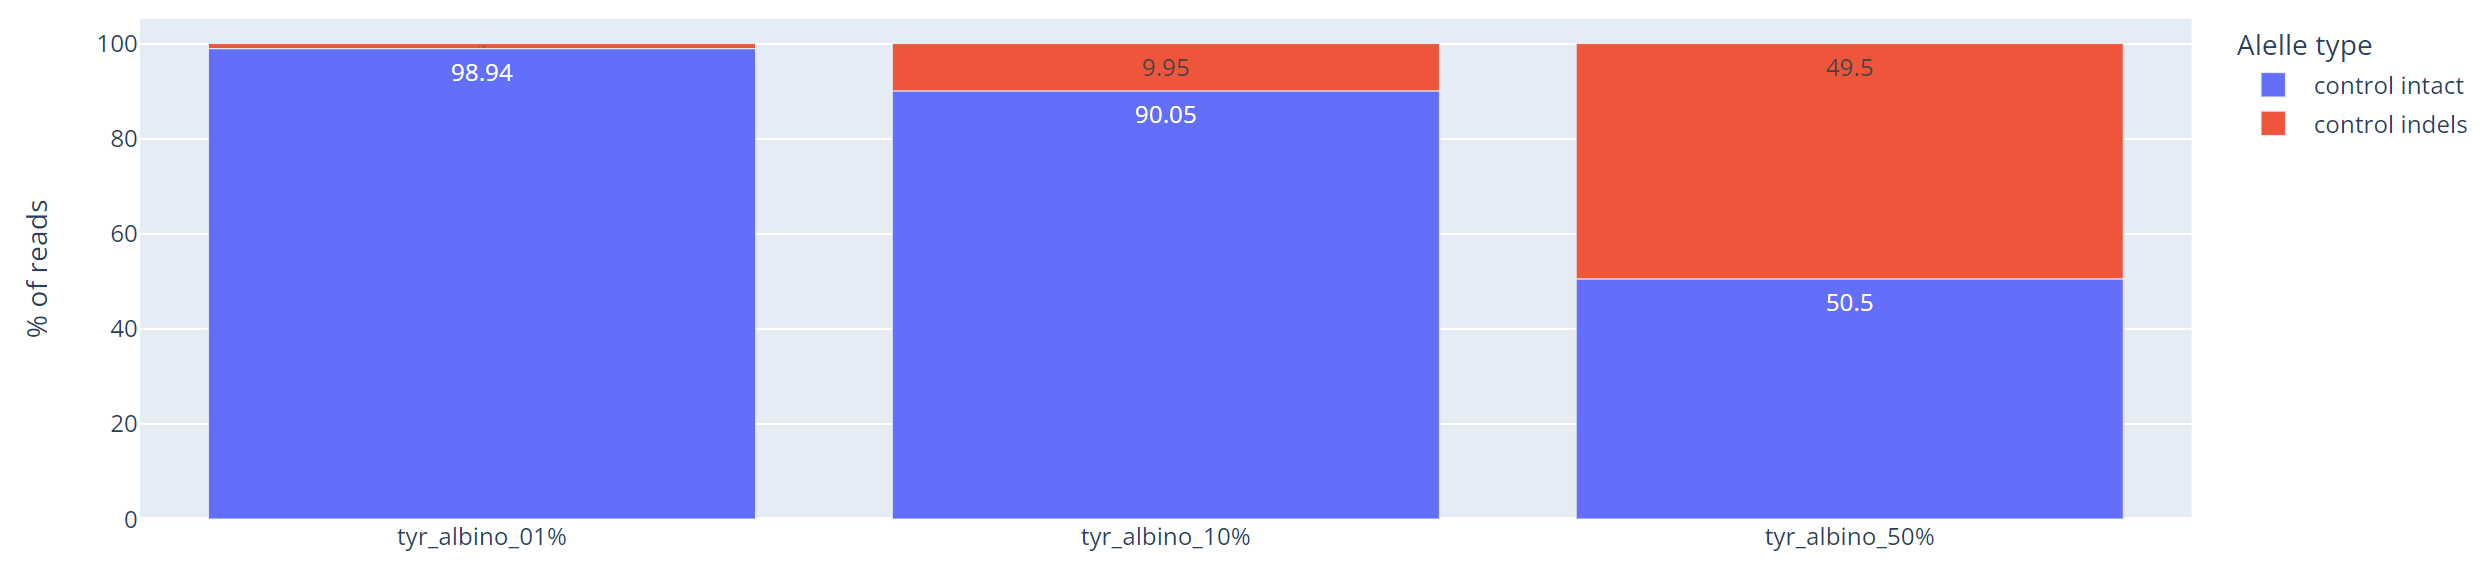

In [125]:
%%bash

pip install -q -e .

rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

2023-06-03 08:05:44: tests/data/knockout/test_barcode30.fq.gz is now processing...
2023-06-03 08:05:49: Preprocess tests/data/knockout/test_barcode30.fq.gz...
2023-06-03 08:05:49: Mapping tests/data/knockout/test_barcode30.fq.gz...
2023-06-03 08:05:58: Call MIDSV tests/data/knockout/test_barcode30.fq.gz...
2023-06-03 08:06:05: 🍵 tests/data/knockout/test_barcode30.fq.gz is finished!
2023-06-03 08:06:05: tests/data/knockout/test_barcode25.fq.gz is now processing...
2023-06-03 08:06:07: Preprocess tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 08:06:53: Classify tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 08:06:56: Clustering tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 08:07:08: Consensus calling tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 08:07:12: 🍵 tests/data/knockout/test_barcode25.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-stx2deletion to see the report.

real	1m36.522s
user	1m13.495s
sys	0m2.356s


- 😭残念ながら連続する欠失に対して補正がうまく効いていないようです

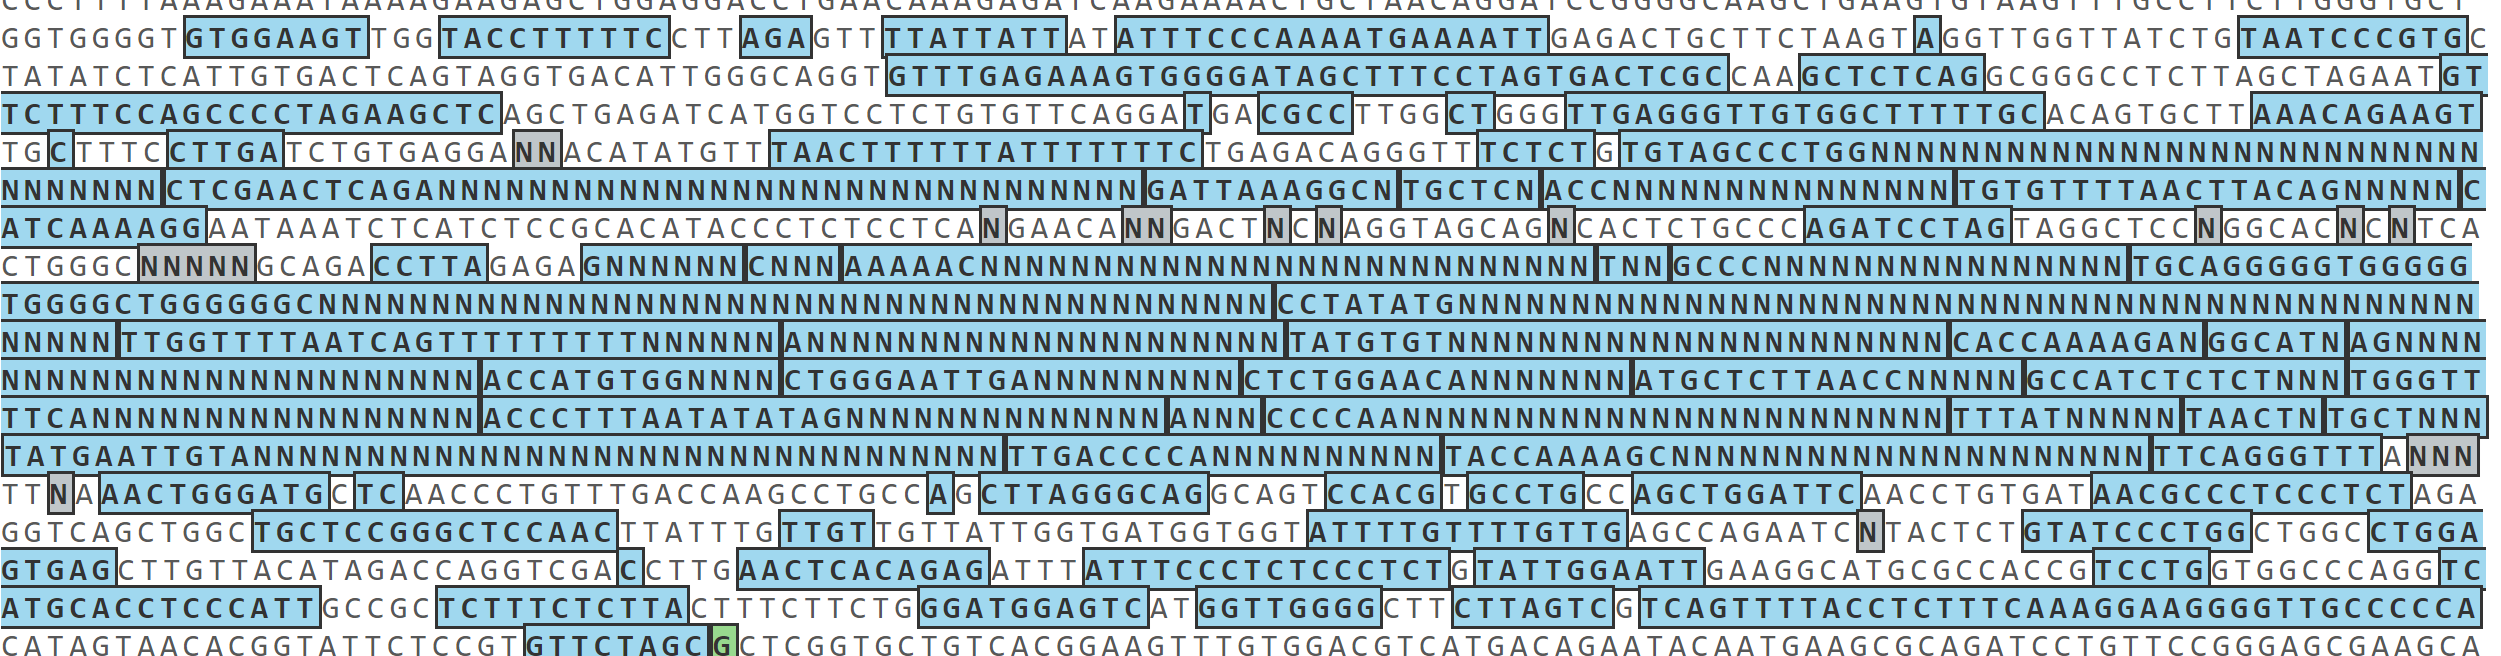

In [126]:
%%bash

pip install -q -e .

rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

2023-06-03 08:08:35: examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
2023-06-03 08:08:39: Preprocess examples/flox-cables2/AyabeTask1/barcode42.fq.gz...
2023-06-03 08:08:39: Mapping examples/flox-cables2/AyabeTask1/barcode42.fq.gz...
2023-06-03 08:08:43: Call MIDSV examples/flox-cables2/AyabeTask1/barcode42.fq.gz...
2023-06-03 08:08:46: 🍵 examples/flox-cables2/AyabeTask1/barcode42.fq.gz is finished!
2023-06-03 08:08:46: examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...
2023-06-03 08:08:48: Preprocess examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 08:09:04: Classify examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 08:09:05: Clustering examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 08:09:13: Consensus calling examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 08:09:20: 🍵 examples/flox-cables2/AyabeTask1/barcode31.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-ayabetask1 to see the

- floxに対しても微妙な結果ですね…

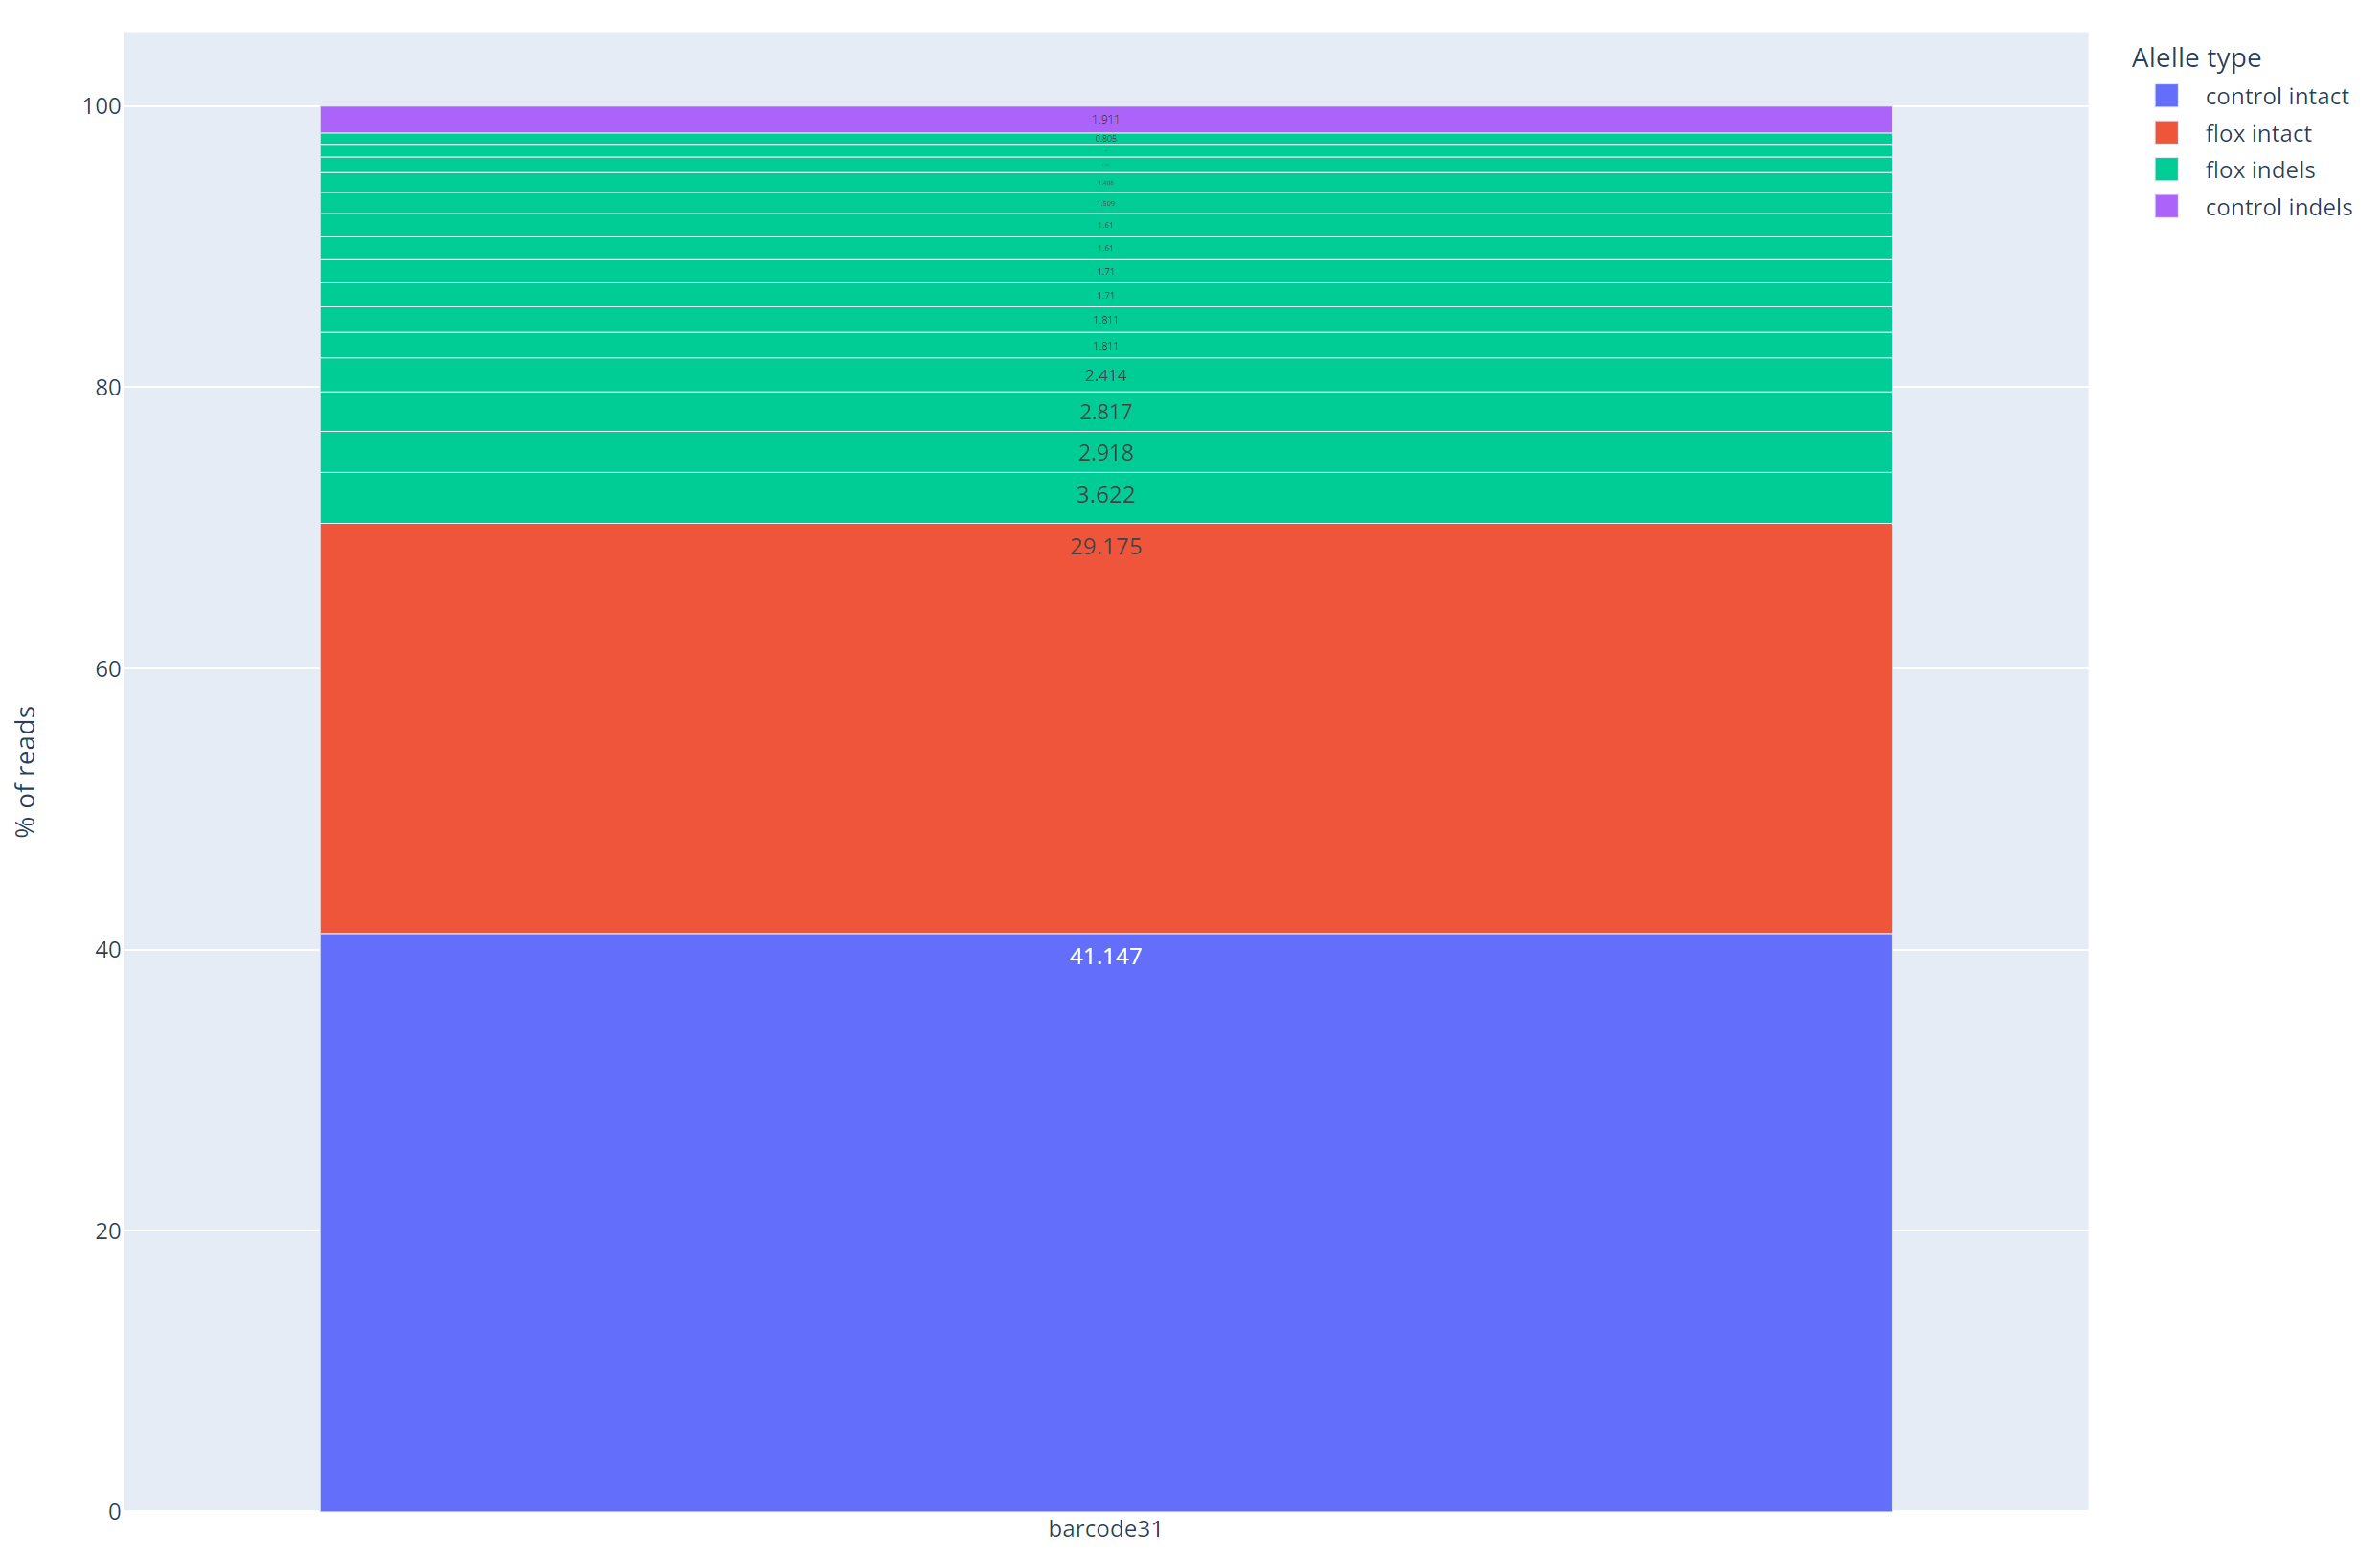

In [127]:
from __future__ import annotations
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "clustering", "report", "result", "mutation_loci"]
SUBDIRS_REPORT = ["HTML", "FASTA", "BAM", ".igvjs"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SUBDIRS_REPORT, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-stx2deletion...


In [129]:
allele = "deletion"
sequence = FASTA_ALLELES[allele]
filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
coverage_sample = count_newlines(filepath_sample)
coverage_control = count_newlines(filepath_control)
indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
indels_kmer_sample = _split_kmer(indels_sample, kmer=10)
indels_kmer_control = _split_kmer(indels_control, kmer=10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, coverage_sample, coverage_control)
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)

In [140]:
mut = "-"

kmer_sample = indels_kmer_sample[mut]
kmer_control = indels_kmer_control[mut]
# Calculate cosine similarity: 1 means exactly same, 0 means completely different.
cossim = [1 - distance.cosine(x, y) for x, y in zip(kmer_sample, kmer_control)]
# Perform T-test: nan means exactly same, p > 0.05 means similar in average.
t_pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(kmer_sample, kmer_control)]
# Perform F-test: p > 0.05 means similar in variance.
f_pvalues = [stats.bartlett(x, y)[1] for x, y in zip(kmer_sample, kmer_control)]
# if pvalue == nan or pval > 0.05, samples and controls are similar.
cossim_pval_filter = [
    1 if (t_pval > 0.05 or np.isnan(t_pval)) and f_pval > 0.05 else cossim
    for cossim, t_pval, f_pval in zip(cossim, t_pvalues, f_pvalues)
]
dissimilar_loci = {i for i, x in enumerate(cossim_pval_filter) if x < 0.90}


In [148]:
print(len(dissimilar_loci))
print(1702 in dissimilar_loci)
print(kmer_sample[1702])
print(kmer_control[1702])


779
False
[537, 548, 525, 521, 556, 555, 520, 520, 531, 548]
[37, 44, 32, 23, 83, 79, 23, 19, 38, 55]


In [151]:
idx_del = 1702
print(cossim[idx_del])
print(t_pvalues[idx_del])
print(f_pvalues[idx_del])
print(cossim_pval_filter[idx_del])

0.9065743113242763
1.8272163748277088e-19
0.2126690434561179
0.9065743113242763


In [153]:
idx_del = 45
print(kmer_sample[idx_del])
print(kmer_control[idx_del])
print(cossim[idx_del])
print(t_pvalues[idx_del])
print(f_pvalues[idx_del])
print(cossim_pval_filter[idx_del])

[44, 18, 10, 20, 26, 28, 17, 18, 15, 23]
[31, 16, 3, 5, 14, 15, 10, 14, 6, 12]
0.9681810634670918
0.027766979428149954
0.6158348094816954
0.9681810634670918


In [154]:
kmer_sample = indels_kmer_sample[mut]
kmer_control = indels_kmer_control[mut]
# Calculate cosine similarity: 1 means exactly same, 0 means completely different.
cossim = [1 - distance.cosine(x, y) for x, y in zip(kmer_sample, kmer_control)]
# Perform T-test: nan means exactly same, p > 0.05 means similar in average.
t_pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(kmer_sample, kmer_control)]
t_pvalues = [1 if np.isnan(t) else t for t in t_pvalues]
# Perform F-test: p > 0.05 means similar in variance.
f_pvalues = [stats.bartlett(x, y)[1] for x, y in zip(kmer_sample, kmer_control)]
# if pvalue == nan or pval > 0.05, samples and controls are similar.
dissimilar_loci = set()
for i, (sim, t_pval, f_pval) in enumerate(zip(cossim, t_pvalues, f_pvalues)):
    flag_seqerror = False
    if sim > 0.90 and t_pval > 0.05 and f_pval > 0.05:
        flag_seqerror = True
    if flag_seqerror is False:
        dissimilar_loci.add(i)

In [159]:
idx_del = 140
print(kmer_sample[idx_del])
print(kmer_control[idx_del])
print(cossim[idx_del])
print(t_pvalues[idx_del])
print(f_pvalues[idx_del])
print(dissimilar_loci)
print(1702 in dissimilar_loci)
print(len(dissimilar_loci))

[29, 71, 45, 40, 81, 31, 45, 51, 11, 15]
[21, 34, 22, 11, 37, 14, 28, 39, 13, 12]
0.9665656202074056
0.031680315110212694
0.04275744920518277
{0, 1, 2, 3, 4, 41, 42, 43, 44, 45, 46, 47, 48, 49, 64, 106, 112, 115, 138, 139, 140, 141, 163, 176, 177, 191, 192, 193, 204, 205, 206, 207, 232, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 292, 293, 294, 295, 298, 299, 300, 301, 302, 303, 304, 332, 333, 349, 350, 351, 352, 353, 354, 385, 386, 411, 412, 413, 414, 415, 416, 434, 435, 436, 437, 438, 456, 457, 458, 459, 460, 461, 462, 463, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 538, 539, 540, 541, 542, 543, 545, 546, 570, 571, 572, 573, 584, 586, 626, 627, 628, 629, 646, 647, 648, 649, 665, 666, 679, 715, 716, 717, 718, 719, 721, 722, 723, 724, 725, 740, 741, 742, 743, 761, 762, 767, 768, 769, 770, 771, 796, 797, 798, 810, 81

In [162]:
print(coverage_sample)
print(coverage_control)

1500
1021


In [164]:
count = indels_sample
coverage = coverage_sample
print(count["-"])

[0, 0, 0, 0, 0, 4, 45, 1, 6, 9, 3, 12, 25, 8, 9, 52, 52, 18, 27, 9, 11, 30, 4, 5, 30, 50, 29, 43, 23, 77, 30, 216, 42, 73, 91, 37, 19, 26, 12, 20, 44, 18, 10, 20, 26, 28, 17, 18, 15, 23, 25, 22, 12, 34, 223, 36, 24, 49, 119, 21, 14, 18, 15, 29, 10, 16, 19, 14, 30, 58, 29, 42, 27, 43, 5, 10, 28, 47, 7, 13, 10, 139, 164, 421, 47, 23, 45, 5, 19, 17, 65, 16, 22, 25, 54, 48, 71, 19, 41, 45, 137, 20, 14, 21, 33, 38, 99, 25, 9, 7, 35, 49, 32, 21, 37, 25, 38, 103, 60, 49, 69, 100, 44, 29, 25, 32, 18, 38, 43, 19, 93, 31, 223, 34, 14, 29, 71, 45, 40, 81, 31, 45, 51, 11, 15, 19, 15, 7, 21, 39, 593, 71, 19, 18, 27, 30, 59, 58, 51, 3, 3, 11, 12, 79, 20, 23, 7, 11, 35, 4, 5, 17, 16, 61, 11, 16, 13, 40, 60, 33, 73, 58, 55, 22, 14, 15, 13, 38, 12, 14, 12, 13, 23, 18, 14, 83, 28, 19, 71, 32, 15, 19, 20, 16, 20, 24, 48, 21, 21, 11, 17, 46, 67, 12, 14, 24, 13, 79, 13, 72, 27, 32, 17, 66, 24, 19, 34, 35, 86, 98, 98, 24, 54, 14, 79, 47, 47, 36, 34, 46, 38, 88, 28, 51, 28, 33, 31, 26, 33, 18, 341, 30, 30, 5

In [165]:
count_normalized = dict()
for mut in count:
    count_normalized[mut] = [x / coverage for x in count[mut]]

In [168]:
from __future__ import annotations

import re
from collections import defaultdict
import json
import numpy as np
from pathlib import Path
from typing import Generator
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def read_midsv(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def _make_gen(reader):
    while True:
        b = reader(2**16)
        if not b:
            break
        yield b


def count_newlines(filepath):
    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count


def _count_indels(midsv_sample, len_sequence: int) -> dict[str, list[int]]:
    count = {"+": [0] * len_sequence, "-": [0] * len_sequence, "*": [0] * len_sequence}
    for samp in midsv_sample:
        for i, cs in enumerate(samp["CSSPLIT"].split(",")):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["+"][i] += len(cs.split("|"))
                count["+"][i] += 1
            elif cs.startswith("-"):
                count["-"][i] += 1
            elif cs.startswith("*"):
                count["*"][i] += 1
    return count


def _normalize_indels(count: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_normalized = dict()
    for mut in count:
        count_normalized[mut] = [x / coverage for x in count[mut]]
    return count_normalized


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start:end])
            else:
                results[mut].append([0] * kmer)
    return results


def _extract_anomaly_loci(
    indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int
) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=5)
    for mut in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[mut]) / coverage_control
        values_sample = np.array(indels_kmer_sample[mut]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # If the next base is not -1, do not validate the next base because the next base is not an outlier.
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({mut: loci})
    return anomaly_loci


def _extract_dissimilar_loci(
    indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]
) -> dict[str, set]:
    """
    「類似度が高い＆平均値が似ている＆分散が似ている」ものはシークエンスエラー
    """
    results = dict()
    for mut in indels_kmer_sample:
        kmer_sample = indels_kmer_sample[mut]
        kmer_control = indels_kmer_control[mut]
        # Calculate cosine similarity: 1 means exactly same, 0 means completely different.
        cossim = [1 - distance.cosine(x, y) for x, y in zip(kmer_sample, kmer_control)]
        # Perform T-test: nan means exactly same, p > 0.05 means similar in average.
        t_pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(kmer_sample, kmer_control)]
        t_pvalues = [1 if np.isnan(t) else t for t in t_pvalues]
        # Perform F-test: p > 0.05 means similar in variance.
        f_pvalues = [stats.bartlett(x, y)[1] for x, y in zip(kmer_sample, kmer_control)]
        # if pvalue == nan or pval > 0.05, samples and controls are similar.
        dissimilar_loci = set()
        for i, (sim, t_pval, f_pval) in enumerate(zip(cossim, t_pvalues, f_pvalues)):
            flag_seqerror = False
            if sim > 0.90 and t_pval > 0.05 and f_pval > 0.05:
                flag_seqerror = True
            if flag_seqerror is False:
                dissimilar_loci.add(i)
        # cossim_pval_filter = [
        #     1 if (t_pval > 0.05 or np.isnan(t_pval)) and f_pval > 0.05 else cossim
        #     for cossim, t_pval, f_pval in zip(cossim, t_pvalues, f_pvalues)
        # ]
        # dissimilar_loci = {i for i, x in enumerate(cossim_pval_filter) if x < 0.90}
        results.update({mut: dissimilar_loci})
    return results


def _transpose_mutation_loci(mutation_loci, len_sequence):
    mutation_loci_transposed = [set() for _ in range(len_sequence)]
    for mut, idx_mutation in mutation_loci.items():
        for i, loci in enumerate(mutation_loci_transposed):
            if i in idx_mutation:
                loci.add(mut)
    return mutation_loci_transposed


###########################################################
# main
###########################################################


def extract_mutation_loci(
    TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME: str
) -> dict[str, list[set[str]]]:
    MUTATION_LOCI_ALLELES = dict()
    for allele, sequence in FASTA_ALLELES.items():
        filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
        filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        coverage_sample = count_newlines(filepath_sample)
        coverage_control = count_newlines(filepath_control)
        indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
        indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
        indels_sample_normalized = _normalize_indels(indels_sample, coverage_sample)
        indels_control_normalized = _normalize_indels(indels_control, coverage_control)
        indels_kmer_sample = _split_kmer(indels_sample_normalized, kmer=10)
        indels_kmer_control = _split_kmer(indels_control_normalized, kmer=10)
        anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, coverage_sample, coverage_control)
        dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
        mutation_loci = dict()
        for mut in anomaly_loci:
            mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
        mutation_loci_transposed = _transpose_mutation_loci(mutation_loci, len(sequence))
        MUTATION_LOCI_ALLELES.update({allele: mutation_loci_transposed})
    return MUTATION_LOCI_ALLELES


In [169]:
filepath_sample = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json")
filepath_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
coverage_sample = count_newlines(filepath_sample)
coverage_control = count_newlines(filepath_control)
indels_sample = _count_indels(read_midsv(filepath_sample), len(sequence))
indels_control = _count_indels(read_midsv(filepath_control), len(sequence))
indels_sample_normalized = _normalize_indels(indels_sample, coverage_sample)
indels_control_normalized = _normalize_indels(indels_control, coverage_control)
indels_kmer_sample = _split_kmer(indels_sample_normalized, kmer=10)
indels_kmer_control = _split_kmer(indels_control_normalized, kmer=10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, coverage_sample, coverage_control)
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)


In [170]:
mut = "-"
print(1702 in anomaly_loci[mut])
print(dissimilar_loci[mut])
print(1702 in dissimilar_loci[mut])
print(len(dissimilar_loci[mut]))

True
{0, 1, 2, 3, 4, 169, 170, 171, 172, 173, 174, 175, 176, 177, 527, 528, 529, 530, 531, 532, 533, 534, 540, 665, 666, 1001, 1002, 1070, 1071, 1072, 1073, 1074, 1075, 1156, 1259, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 144

- `extract_mutation_loci`のアルゴリズムを変更しました
    - リード数に
    - `_extract_dissimilar_loci`のアルゴリズムを変更しました
    - 

In [175]:
%%bash

pip install -q -e .

rm -rf DAJINResults/single-stx2-barcode25
rm -rf DAJINResults/.tempdir/single-stx2-barcode25

time DAJIN2 \
    --name single-stx2-barcode25 \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

2023-06-03 09:53:55: tests/data/knockout/test_barcode30.fq.gz is now processing...
2023-06-03 09:53:58: Preprocess tests/data/knockout/test_barcode30.fq.gz...
2023-06-03 09:53:58: Mapping tests/data/knockout/test_barcode30.fq.gz...
2023-06-03 09:54:08: Call MIDSV tests/data/knockout/test_barcode30.fq.gz...
2023-06-03 09:54:15: 🍵 tests/data/knockout/test_barcode30.fq.gz is finished!
2023-06-03 09:54:15: tests/data/knockout/test_barcode25.fq.gz is now processing...
2023-06-03 09:54:17: Preprocess tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 09:55:04: Classify tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 09:55:07: Clustering tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 09:55:20: Consensus calling tests/data/knockout/test_barcode25.fq.gz...
2023-06-03 09:55:25: 🍵 tests/data/knockout/test_barcode25.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-stx2-barcode25 to see the report.

real	1m39.684s
user	1m16.975s
sys	0m2.176s


- Stx2 deletion, いい感じになりました！

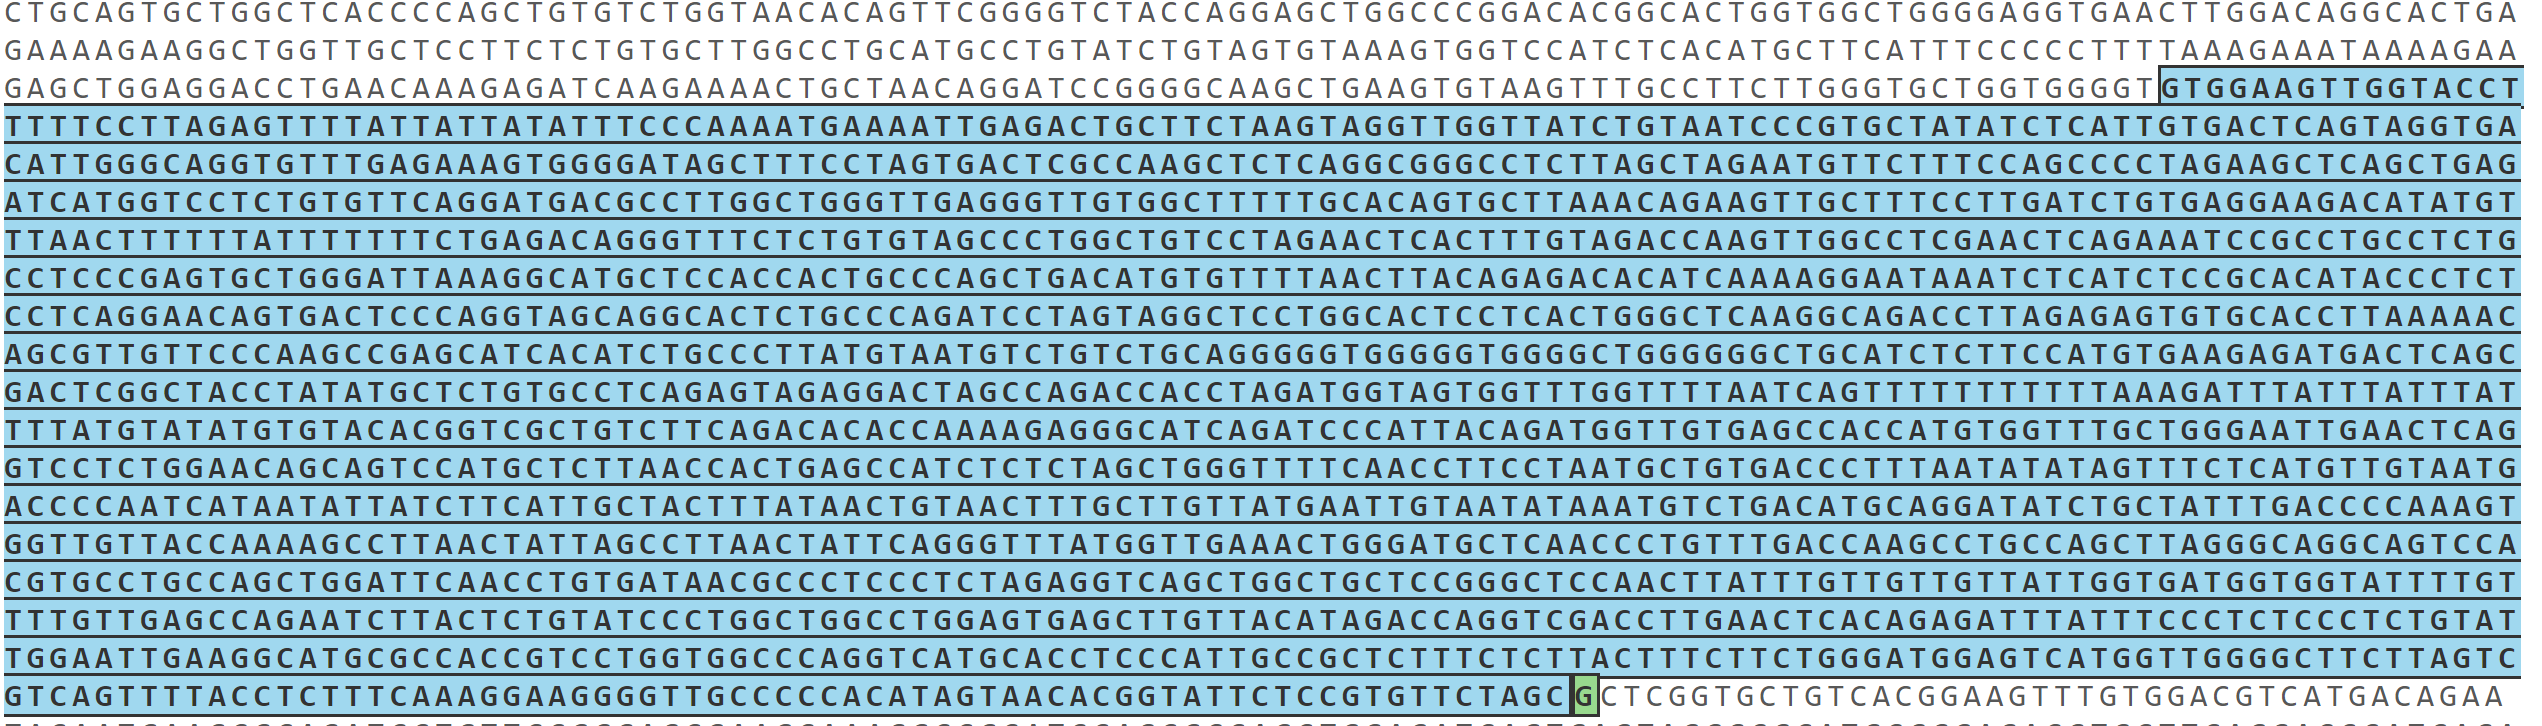

In [176]:
%%bash

pip install -q -e .

rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

2023-06-03 09:58:26: examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
2023-06-03 09:58:30: Preprocess examples/flox-cables2/AyabeTask1/barcode42.fq.gz...
2023-06-03 09:58:30: Mapping examples/flox-cables2/AyabeTask1/barcode42.fq.gz...
2023-06-03 09:58:34: Call MIDSV examples/flox-cables2/AyabeTask1/barcode42.fq.gz...
2023-06-03 09:58:37: 🍵 examples/flox-cables2/AyabeTask1/barcode42.fq.gz is finished!
2023-06-03 09:58:37: examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...
2023-06-03 09:58:39: Preprocess examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 09:58:55: Classify examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 09:58:56: Clustering examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 09:59:03: Consensus calling examples/flox-cables2/AyabeTask1/barcode31.fq.gz...
2023-06-03 09:59:05: 🍵 examples/flox-cables2/AyabeTask1/barcode31.fq.gz is finished!
🎉 Finished! Open DAJINResults/single-ayabetask1 to see the

- floxもいい感じになりました！

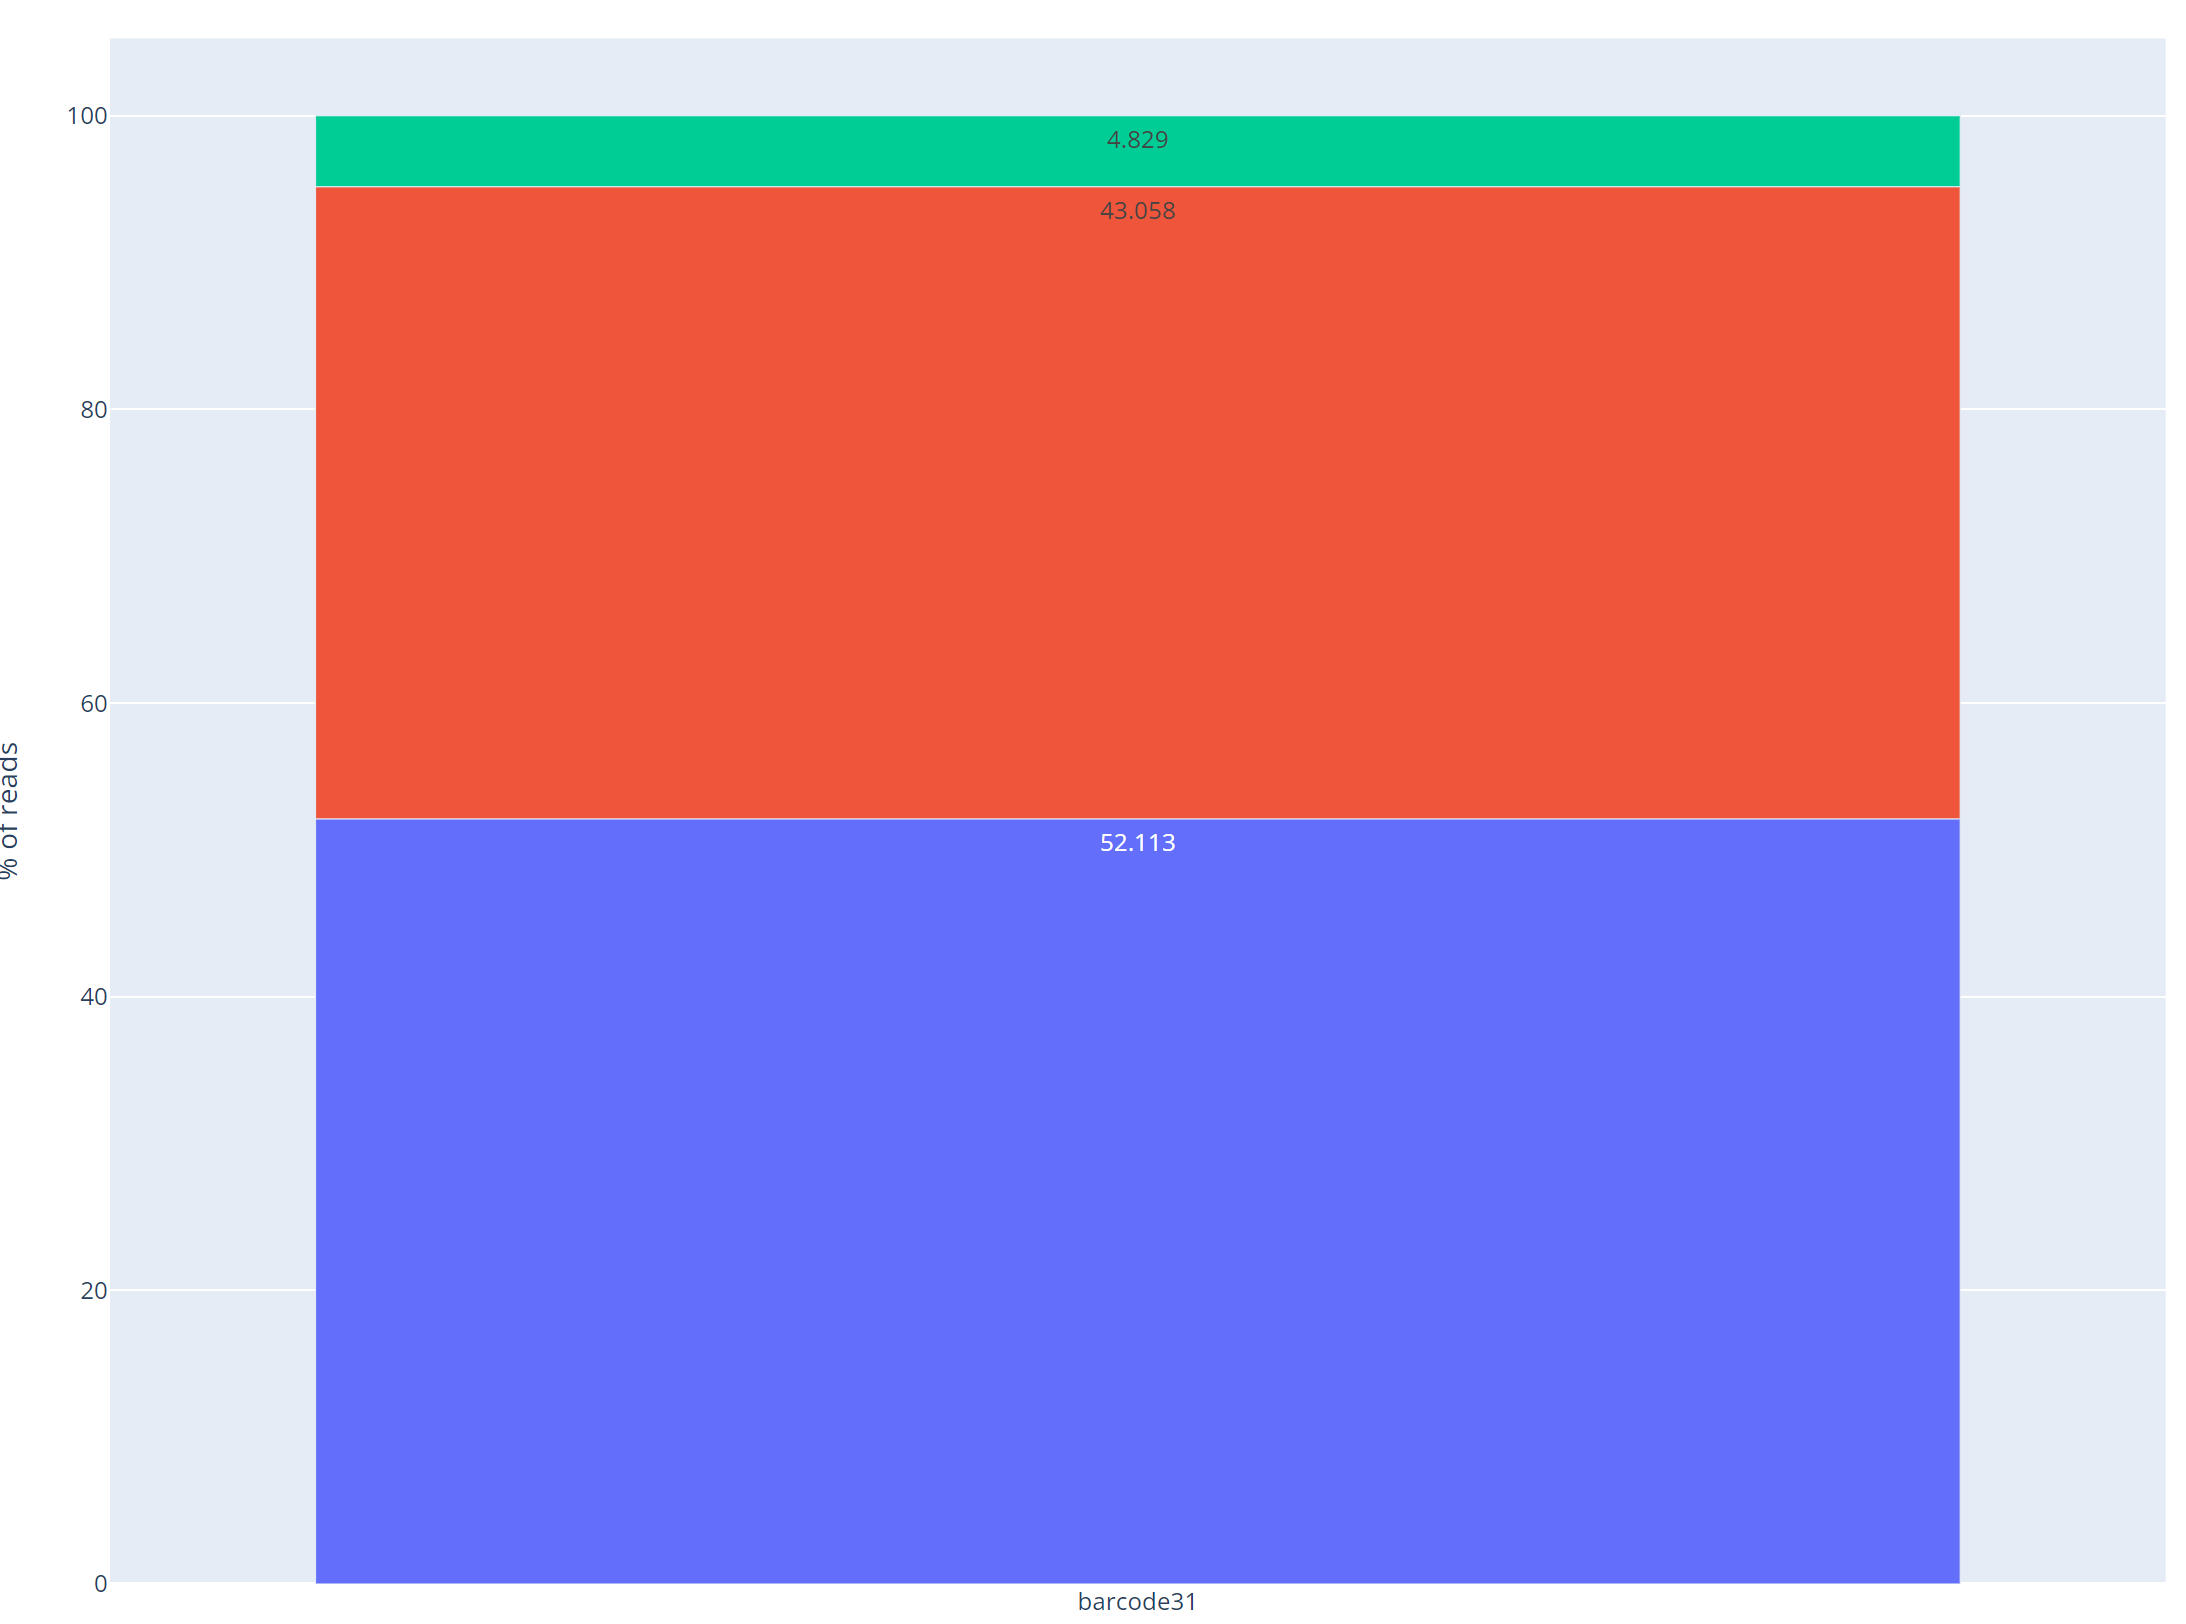

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- barcode31が細かく別れすぎる問題に対応しました
    - 原因はclusteringではなく、`extract_mutation_loci`でした
    - 10merのうち特定の一塩基の変異を検知しきれず、T検定の結果が0.05以上になっていたのが原因でした
    - 分散を考慮することにしました
- **シークエンスエラーの定義を、「コサイン類似度が高い」かつ「T検定で有意差なし」かつ「Bartlett検定で有意差なし」としました**
    - いまのところうまく動いている様子です

# 次に取り組むこと

- ⬜ R10の`barcode05`のように、アレルのクラスタリングのパフォーマンスが良くないサンプルがあるので対応します
    - `R10`の`barcode01`や`barcode02`において、targetアレルの分類性能が悪いようです
        - target intact（点変異）アレルに点変異のないアレルが半分ほどあります
        - `classification`を見直します

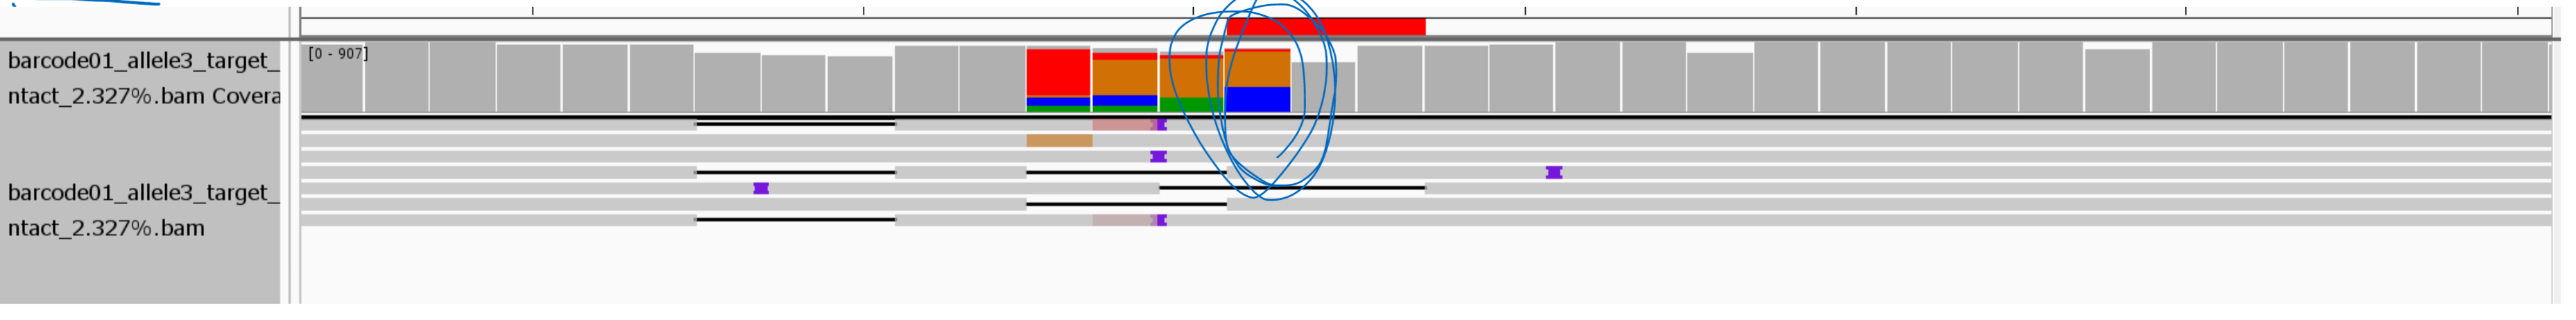

---

- ⬜ `R10`の`barcode05`においてもクラスタリングのパフォーマンスが悪いところが見受けられました
    - コンセンサス配列にも反映されていませんでした

---

- ✅ `R10`において、アルビノのサンプル(`barcode31`)でも非常に細かくクラスタリングされてしまいました
    - **まずは`barcode31`のクラスタリングを見直します**

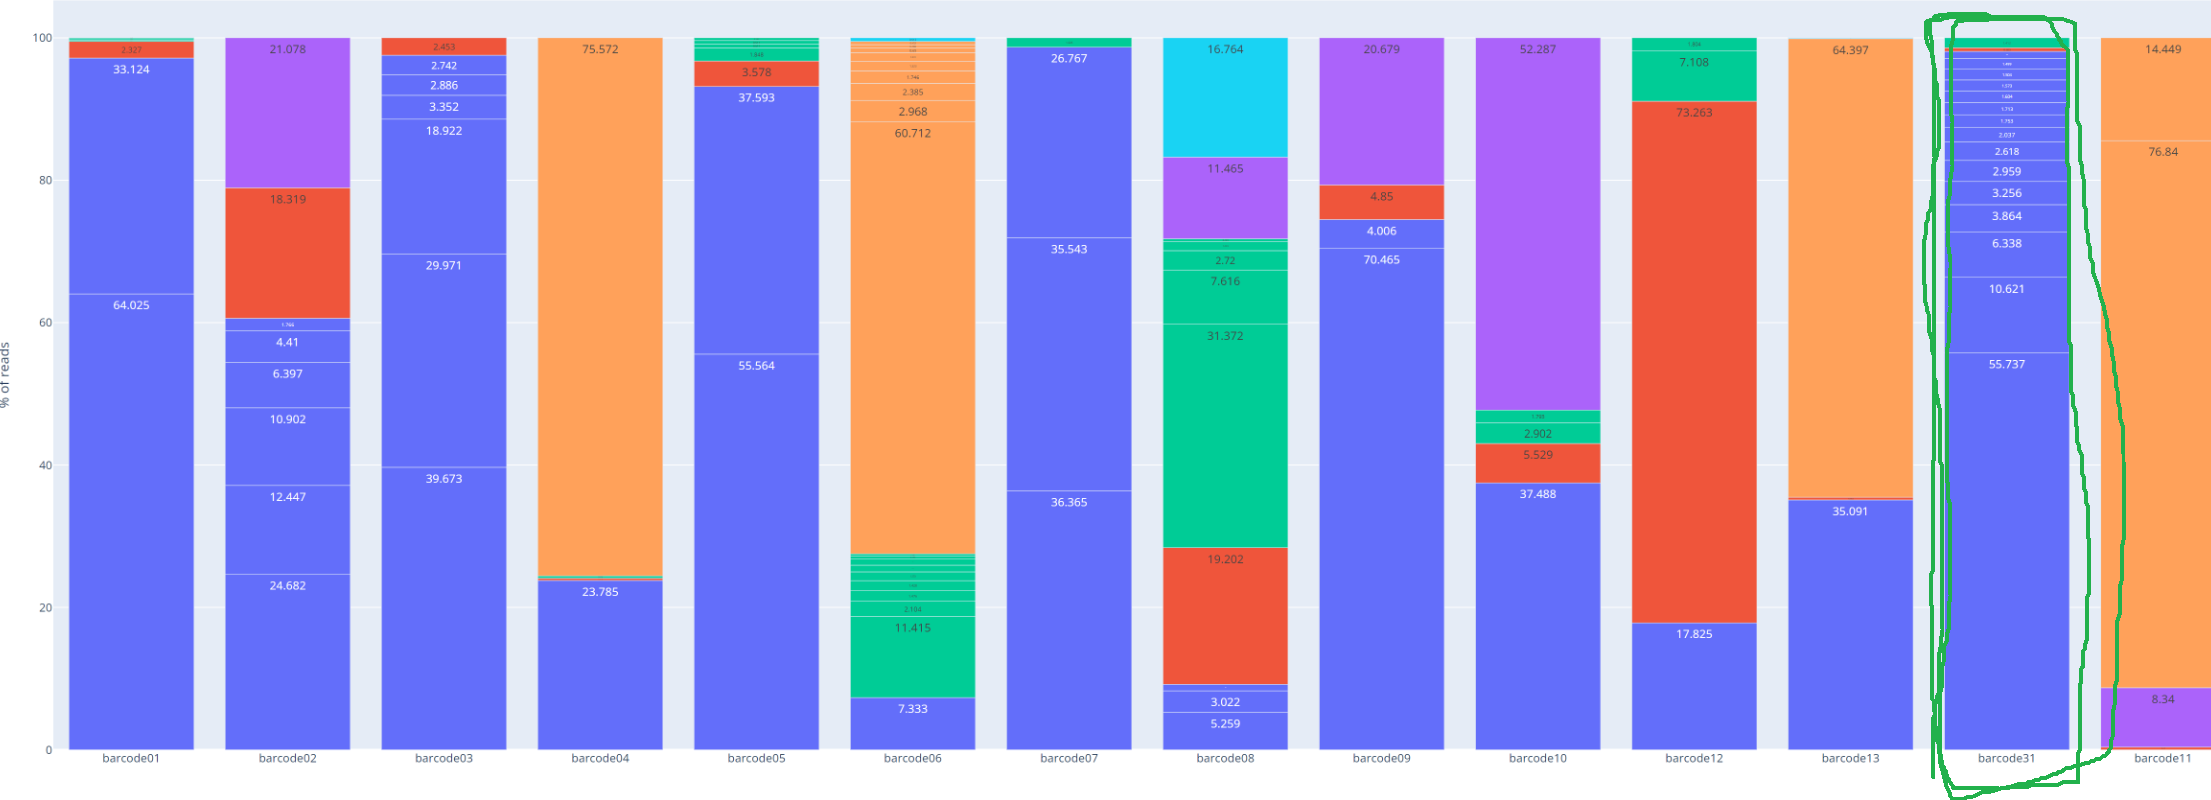



### Lists

+ ⬜ clusteringの性能がいまいち
+ ⬜ 棒グラフの並び順をソートする
+ ⬜ GUIの見栄え
+ ⬜ igv.jsの起動
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
